<div style="padding:10px; margin:0;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 30px 10px;overflow:hidden;font-weight:700;background-color:#272643; color:white">
    Car Plate Digits Detection

# Initializations

## Install Libraries

In [1]:
# ! pip install -q ultralytics

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from termcolor import colored
import cv2
import os
import random
import warnings
from datetime import datetime
import gc
from termcolor import colored
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report 
from PIL import Image
import seaborn as sns

## Libraries Configuarations

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)

sns.set_style('darkgrid')

# Phase 01  - Plate Detection with Ultralytitcs

## Data Loading

In [ ]:
# Path of working-Directory
working_dir = 'C:\\envs\\Working\\Iranian_Plates'

In [227]:
# Path of car-detection dataset
plate_base = 'C:\\envs\\DataSets\\Persian_Car_Plates_YOLOV8'

# Path of yaml file
plate_yaml_path = os.path.join(plate_base, 'data.yaml')

# Path of Train directory
plate_train_dir = os.path.join(plate_base, 'train')
plate_train_images = os.path.join(plate_train_dir, 'images')
plate_train_labels = os.path.join(plate_train_dir, 'labels')

# Path of Validation directory
plate_valid_dir = os.path.join(plate_base, 'valid')
plate_valid_images = os.path.join(plate_valid_dir, 'images')
plate_valid_labels = os.path.join(plate_valid_images, 'labels')

# Path of Test directory
plate_test_dir = os.path.join(plate_base, 'test')
plate_test_images = os.path.join(plate_test_dir, 'images')
plate_test_labels = os.path.join(plate_test_dir, 'labels')

In [6]:
print(colored(f' Number of Train Images : {len(os.listdir(plate_train_images))} ', 'blue', 'on_white', attrs=['bold']))
print(colored(f' Number of Validation Images : {len(os.listdir(plate_valid_images))}', 'blue', 'on_white',  attrs=['bold']))
print(colored(f' Number of Test Images : {len(os.listdir(plate_test_images))} ', 'blue', 'on_white',  attrs=['bold']))
print('_'*70)
print(colored(f' Number of All Images : {len(os.listdir(plate_train_images)) + len(os.listdir(plate_valid_images)) + len(os.listdir(plate_test_images))} ', 'green', 'on_white',  attrs=['bold']))

 Number of Train Images : 219 
 Number of Validation Images : 63
 Number of Test Images : 31 
______________________________________________________________________
 Number of All Images : 313 


## Image Sizes

In [7]:
def Image_Size(train_images) :
    img_sizes = set()

    for img_name in tqdm(os.listdir(train_images)) :
        img_path = os.path.join(train_images, img_name)
        img = cv2.imread(img_path)
        h, w, c = img.shape
        img_sizes.add((h, w))

    return img_sizes

img_sizes = Image_Size(plate_train_images)

if len(img_sizes) == 1 :
    print(colored(f'\n All the images have size of {img_sizes} ', 'white', 'on_green', attrs=['bold']))
else :
    print(colored(f'\n There are {len(img_sizes)} different image sizes ! ', 'white', 'on_red', attrs=['bold']))


100%|██████████| 219/219 [00:00<00:00, 223.08it/s]


 All the images have size of {(640, 640)} 


In [8]:
H = list(img_sizes)[0][0]
W = list(img_sizes)[0][1]

print(H, ',', W)

640 , 640


## Plot Random Images With BBOXs

In [9]:
def TXT_To_BBOX(lbl_path) :
    '''
    Read txt files and extract points of bonding-boxes.
    '''
    bbox = open(lbl_path, 'r')
    bbox = bbox.read()
    bbox = bbox.split(' ')[1:]

    p1 = [int(float(bbox[0])*H), int(float(bbox[1])*W)]
    p2 = [int(float(bbox[2])*H), int(float(bbox[3])*W)]
    p3 = [int(float(bbox[4])*H), int(float(bbox[5])*W)]
    p4 = [int(float(bbox[6])*H), int(float(bbox[7])*W)]

    pts = np.array([p1, p2, p3, p4], np.int32)
    pts = pts.reshape((-1, 1, 2))
    return pts

In [10]:
def JPG_Name_To_TXT(img_name) :
    '''
    Based on image name, find text file in label folder. 
    '''
    name = img_name.split('.')[:-1]
    name = '.'.join(name)
    txt_name = name + '.txt'
    return txt_name

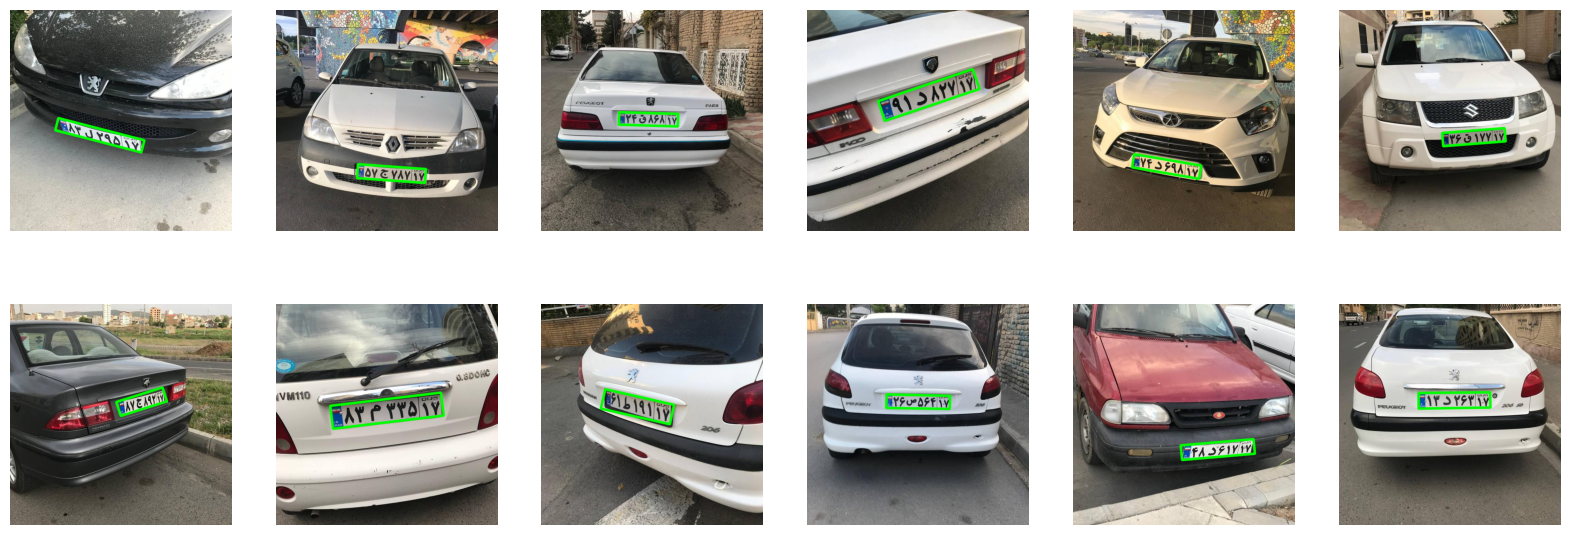

In [11]:
def Plot_Random_Images() :
    '''
    Read and randomly choose some images and plot them with their bboxes in train folder.
    '''
    random_images = random.choices(os.listdir(plate_train_images), k=12)
    i = 1
    plt.figure(figsize=(20, 7))
    for img_name in random_images :
        plt.subplot(2, 6, i)
        # Image
        img_path = os.path.join(plate_train_images, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # BBox
        txt_name = JPG_Name_To_TXT(img_name)
        lbl_path = os.path.join(plate_train_labels, txt_name)
        pts = TXT_To_BBOX(lbl_path)
        cv2.polylines(img, [pts], True, (0, 255, 0), 5, cv2.LINE_AA)

        plt.imshow(img)
        plt.axis('off')
        i += 1
Plot_Random_Images()

## Model1 - Plate Detector

In [12]:
yolo_model = YOLO('yolov8n.yaml').load('yolov8n.pt')

result = yolo_model.train(data=plate_yaml_path, epochs=20, amp=False)

Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.2.48  Python-3.11.7 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=C:\envs\DataSets\Persian Car Plates.v2i.yolov8-obb\data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_f

train: Scanning C:\envs\DataSets\Persian Car Plates.v2i.yolov8-obb\train\labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]
val: Scanning C:\envs\DataSets\Persian Car Plates.v2i.yolov8-obb\valid\labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.66G      1.176      3.132      1.213         23        640: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         63         63    0.00333          1      0.871      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.66G     0.8821      1.687     0.9046         17        640: 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         63         63    0.00328      0.984      0.827       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.66G     0.8744      1.448     0.9549         18        640: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         63         63    0.00328      0.984      0.964      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.66G     0.8771      1.355     0.9252         20        640: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         63         63          1      0.151      0.843      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.66G     0.8517      1.298     0.9504         18        640: 100%|██████████| 14/14 [00:06<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         63         63      0.977      0.676      0.927      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.66G     0.8641      1.241     0.9556         22        640: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         63         63      0.946      0.952      0.981       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.66G     0.7927      1.153     0.9405         16        640: 100%|██████████| 14/14 [00:06<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         63         63      0.978      0.952      0.983      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.66G     0.7501      1.029     0.9094         21        640: 100%|██████████| 14/14 [00:06<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         63         63      0.966      0.952      0.972      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.66G     0.7427     0.9991     0.9351         19        640: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         63         63      0.968      0.968      0.987      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.66G       0.71     0.9149     0.9225         13        640: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         63         63      0.977      0.921      0.978      0.831


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.66G     0.6356      1.073     0.8918         11        640: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         63         63      0.969      0.998      0.994      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.66G     0.6238      1.007     0.9032         11        640: 100%|██████████| 14/14 [00:06<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         63         63      0.983      0.984      0.992      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.66G     0.5951      0.932     0.8853         11        640: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         63         63      0.984      0.983      0.987      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.66G     0.5892     0.8651     0.8735         11        640: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         63         63      0.983      0.984      0.994      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.66G     0.5907     0.8598     0.8905         11        640: 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         63         63      0.982      0.984      0.988      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.66G     0.5569      0.815     0.8721         11        640: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         63         63      0.982      0.984      0.989      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.66G     0.4726     0.7555     0.8315         11        640: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         63         63      0.984      0.981      0.989      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.66G     0.4707     0.7392     0.8284         11        640: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         63         63      0.984      0.983      0.989      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.66G     0.4583     0.7201     0.8441         11        640: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         63         63      0.984      0.984       0.99       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.66G     0.4284      0.684     0.8231         11        640: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         63         63      0.984      0.984      0.992      0.919



20 epochs completed in 0.056 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.48  Python-3.11.7 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


                   all         63         63      0.984      0.984      0.992      0.919
Speed: 0.2ms preprocess, 18.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train


In [13]:
# Location of stored result
result_path = result.save_dir

## Train Result

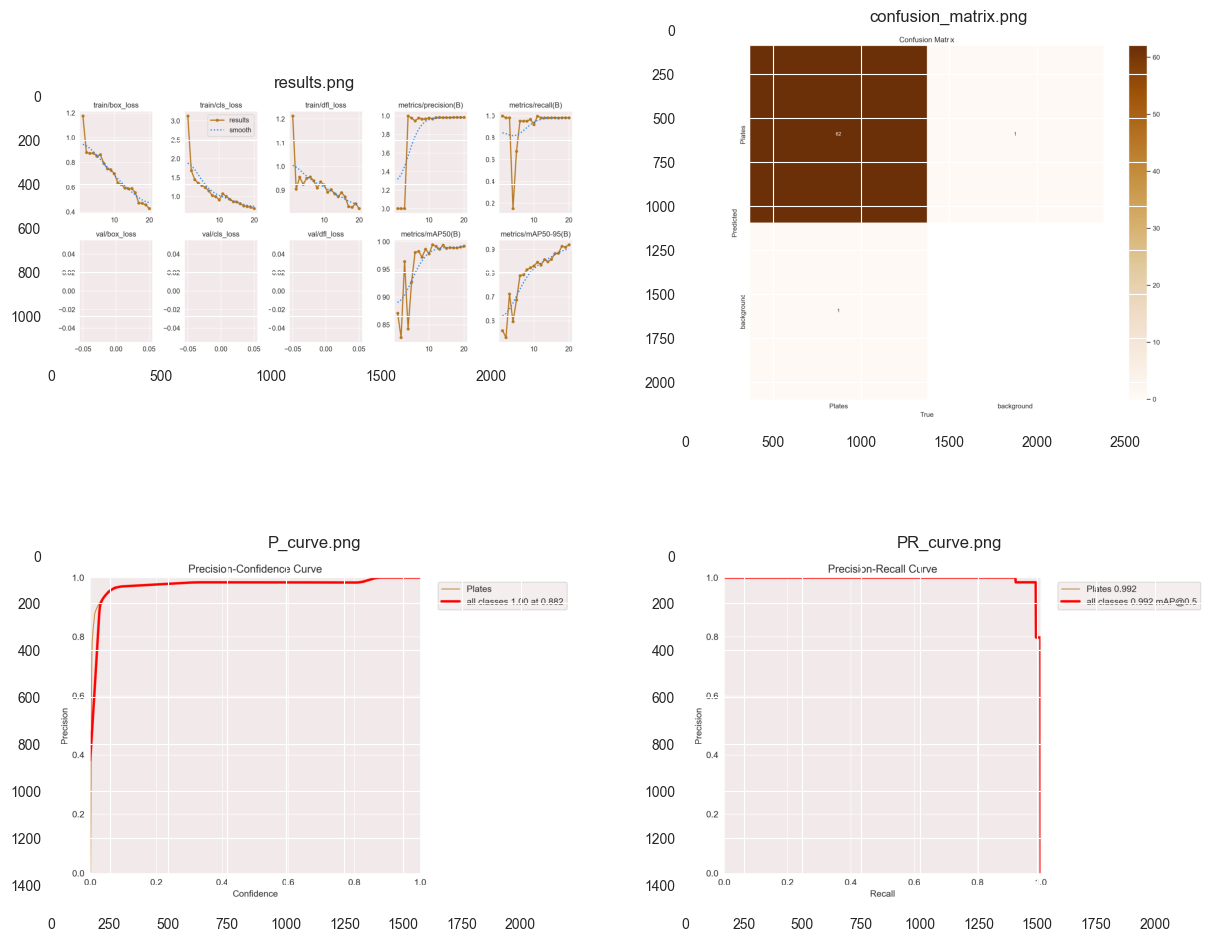

In [14]:
# List of some metrics
metrics = ['results.png','confusion_matrix.png', 'P_curve.png', 'PR_curve.png']

plt.figure(figsize=(15, 12))
i = 1

for image_name in metrics:
    image_path = os.path.join(result_path, image_name)
    image = cv2.imread(image_path)
    
    plt.subplot(2, 2, i)
    
    plt.imshow(image)
    plt.title(image_name)
    i += 1

plt.show()

In [15]:
# Read csv of result
df = pd.read_csv(os.path.join(result_path, 'results.csv'))
df.tail(5)

epoch        train/box_loss        train/cls_loss  \
15                    16               0.55689               0.81500   
16                    17               0.47255               0.75552   
17                    18               0.47068               0.73918   
18                    19               0.45833               0.72014   
19                    20               0.42837               0.68395   

          train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
15               0.87207               0.98248               0.98413   
16               0.83147               0.98407               0.98056   
17               0.82839               0.98411               0.98333   
18               0.84407               0.98412               0.98363   
19               0.82312               0.98412               0.98393   

        metrics/mAP50(B)   metrics/mAP50-95(B)             val/box_loss  \
15               0.98943               0.88263                      nan   
16               0.98872               0.88459                      nan   
17               0.98875               0.91322                      nan   
18               0.99043               0.90958                      nan   
19               0.99202               0.91930                      nan   

               val/cls_loss             val/dfl_loss                lr/pg0  \
15                      nan                      nan              0.000515   
16                      nan                      nan              0.000416   
17                      nan                      nan              0.000317   
18                      nan                      nan              0.000218   
19                      nan                      nan              0.000119   

                  lr/pg1                lr/pg2  
15              0.000515              0.000515  
16              0.000416              0.000416  
17              0.000317              0.000317  
18              0.000218              0.000218  
19              0.000119              0.000119

In [16]:
# Strip columns
df.columns = df.columns.str.strip()
df.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

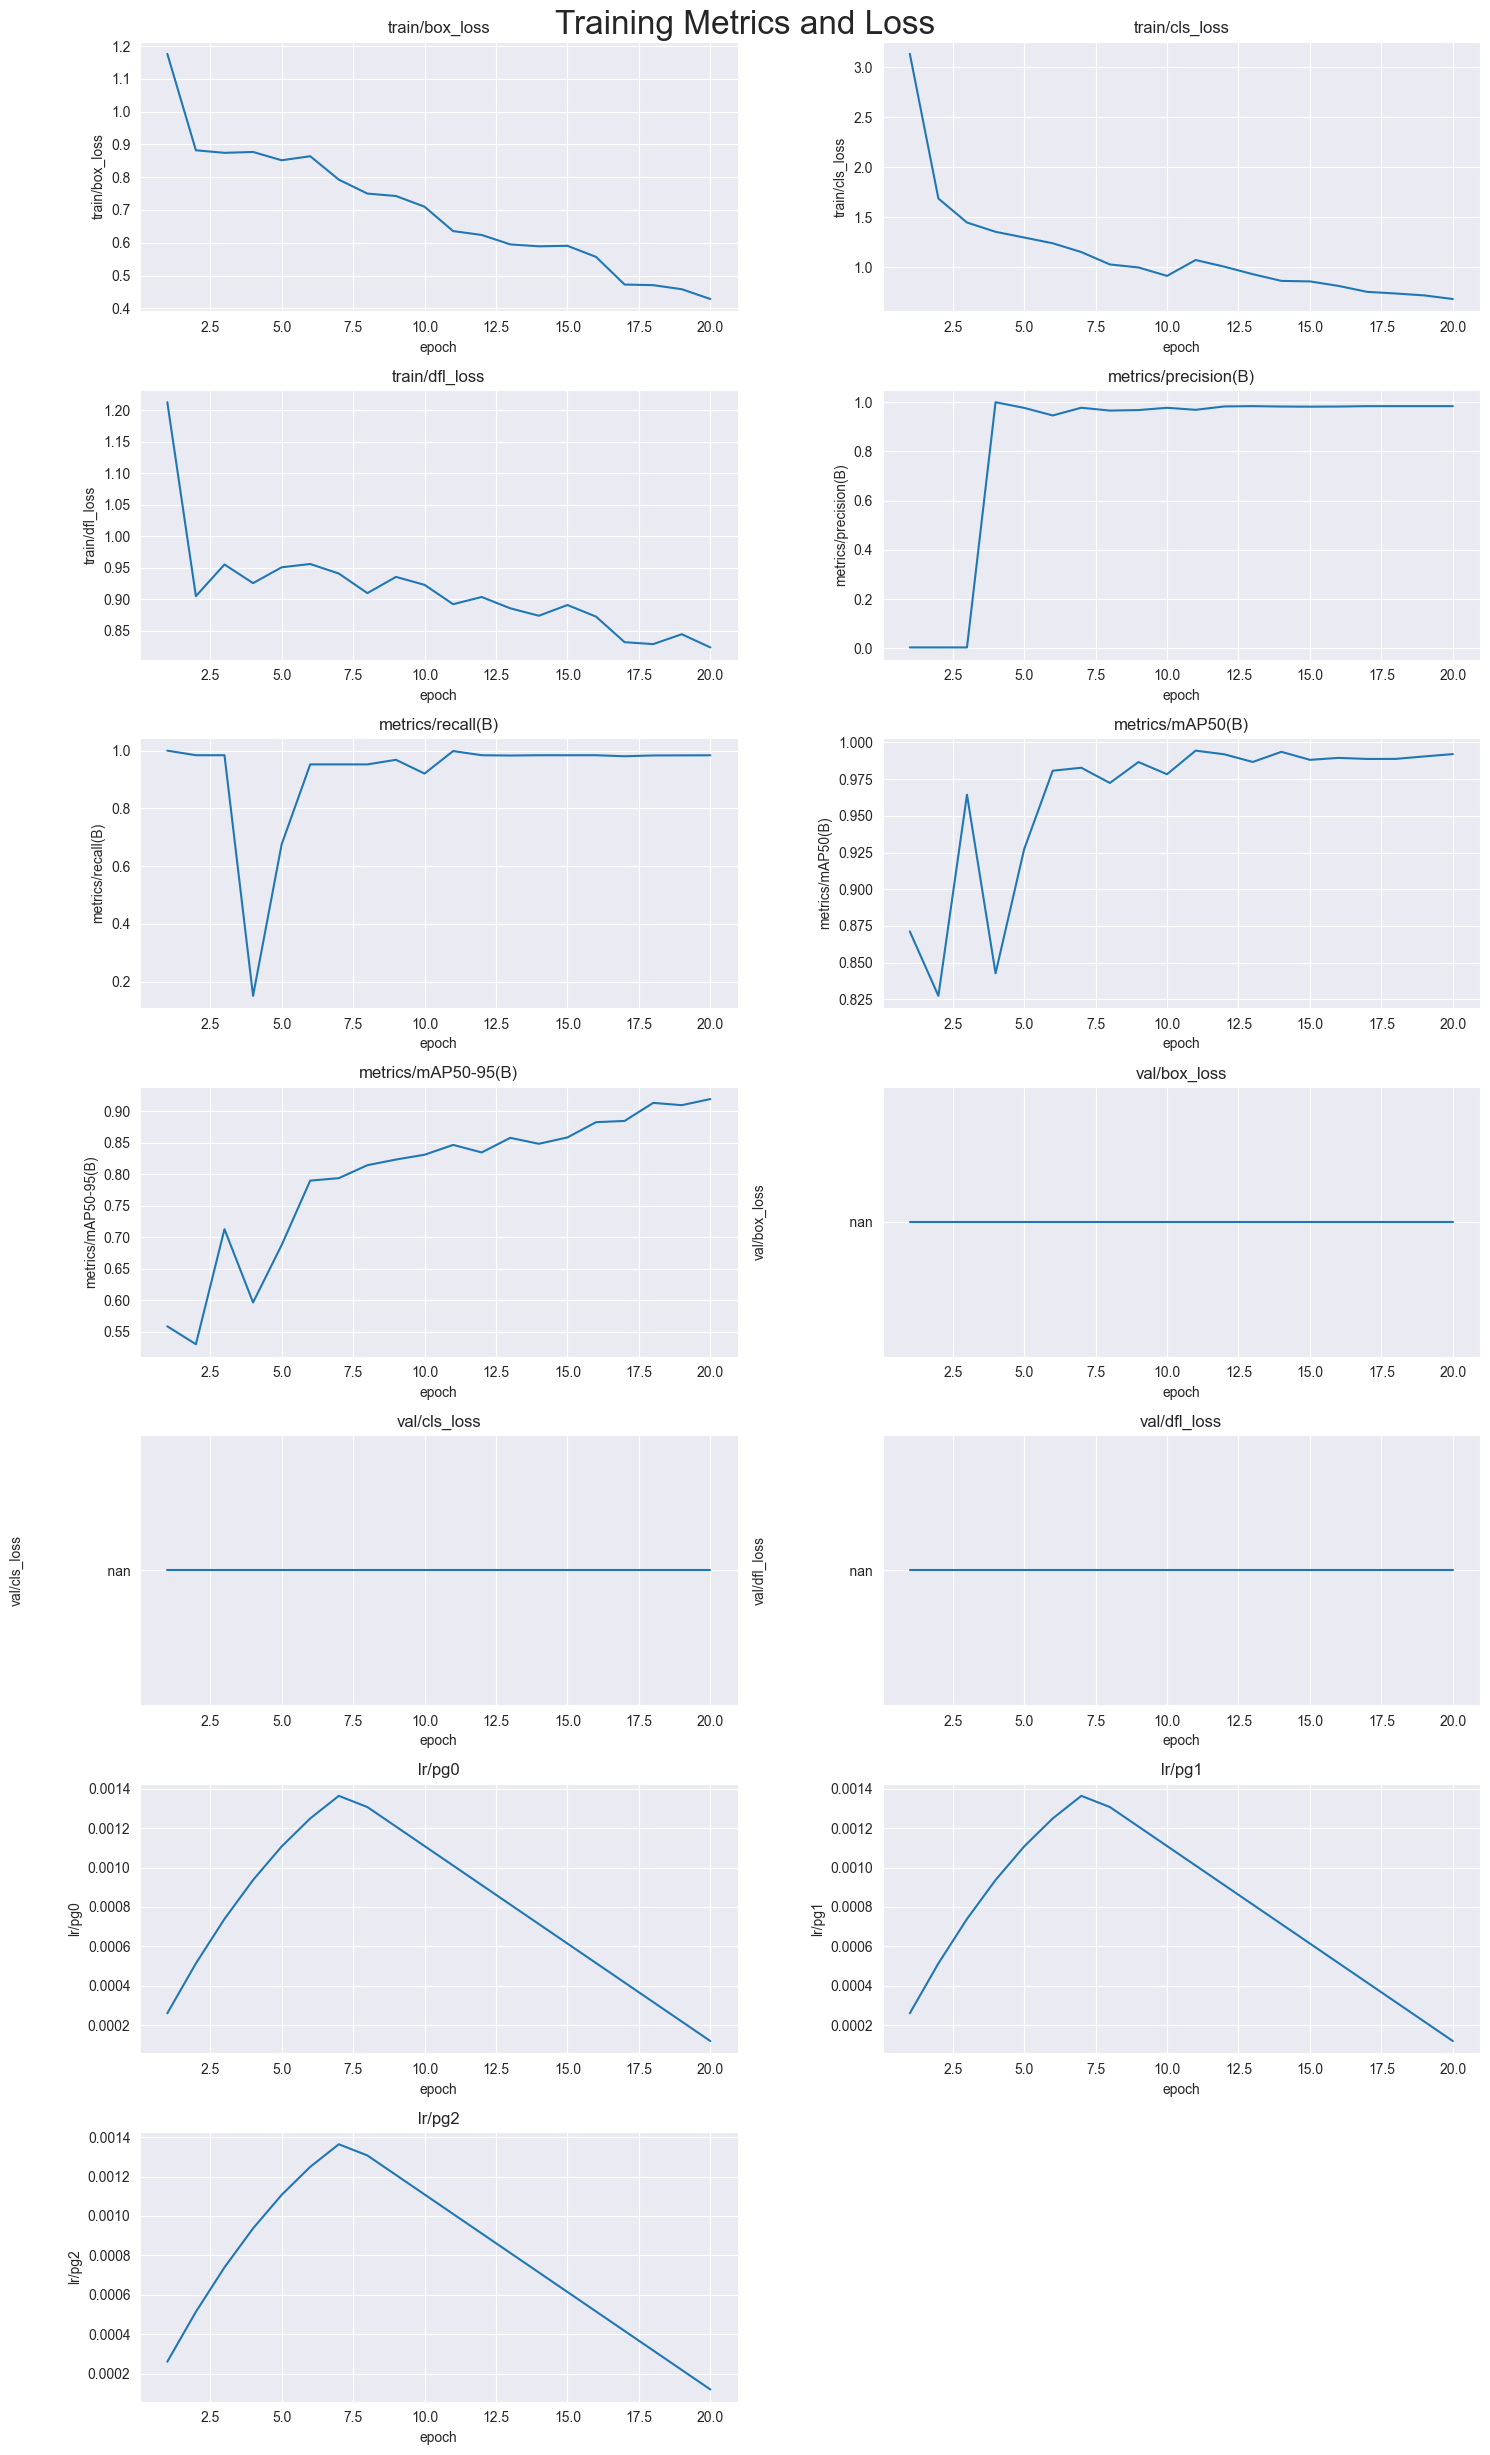

In [17]:
# Define X, y to plot
X = df.epoch
cols = df.columns[1:]

plt.figure(figsize=(15, 25))

for it in range(len(cols)) :
    plt.subplot(7, 2, it+1)
    ax = sns.lineplot(data=df, x=X, y=cols[it])
    ax.set_title(cols[it])
plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.6)
plt.tight_layout()
plt.show()

In [18]:
# Load model with best weights
best_model_path = os.path.join(result_path, 'weights/best.pt')

best_model_plate = YOLO(best_model_path)

In [19]:
# Evaluating the model
result_test = best_model_plate.val()

Ultralytics YOLOv8.2.48  Python-3.11.7 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\envs\DataSets\Persian Car Plates.v2i.yolov8-obb\valid\labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


                   all         63         63      0.997          1      0.995       0.91
Speed: 1.7ms preprocess, 10.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\val


In [20]:
result_test

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002217BEC6BD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [21]:
keys = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

for key in keys :
    print(colored(f'{key} : {result_test.results_dict[key]}', 'green', attrs=['bold']))

metrics/precision(B) : 0.9965329369330659
metrics/recall(B) : 1.0
metrics/mAP50(B) : 0.995
metrics/mAP50-95(B) : 0.9099170095381212


## Test the first model

In [22]:
images = os.listdir(plate_test_images)
num_samples = 12

random_images = random.choices(images, k=num_samples)

images = []
for image in random_images :
    image_path = os.path.join(plate_test_images, image)
    images.append(image_path)

images

['C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\462_png.rf.56afd7c388f912b3f984913fc564620b.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\440_png.rf.1c86b3d9d0f61137d64bb0467ec9039e.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\353_png.rf.17c28f6ba6f218385195d8c7fcc34db9.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\301_png.rf.17abf3f5b0b7a9823129bbc60b686d37.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\366_png.rf.050c45f153fde23e2ea6b2e82b88daad.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\350_png.rf.4a48fe7d2dec13ac0ecff6b5ac070296.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\450_png.rf.9ceea270a279a53b8129954e3070abdc.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\311_png.rf.6b6e29efda779df57240502602ee2c94.jpg',
 'C:\\envs\\DataSets\\Persian Ca

In [23]:
for image in images :
    result = best_model_plate.predict([image], save=True, conf=0.5, iou=0.7) 


0: 640x640 1 Plates, 13.5ms
Speed: 3.0ms preprocess, 13.5ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3

0: 640x640 1 Plates, 19.9ms
Speed: 0.0ms preprocess, 19.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3

0: 640x640 1 Plates, 18.6ms
Speed: 0.0ms preprocess, 18.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3

0: 640x640 1 Plates, 20.3ms
Speed: 0.0ms preprocess, 20.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3

0: 640x640 1 Plates, 16.0ms
Speed: 0.0ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3

0: 640x640 1 Plates, 19.9ms
Speed: 0.0ms preprocess, 19.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3

0: 640x640 1 Pl

In [24]:
# Location of saved predicted images
result_path = result[0].save_dir
print(result_path)

runs\detect\predict3


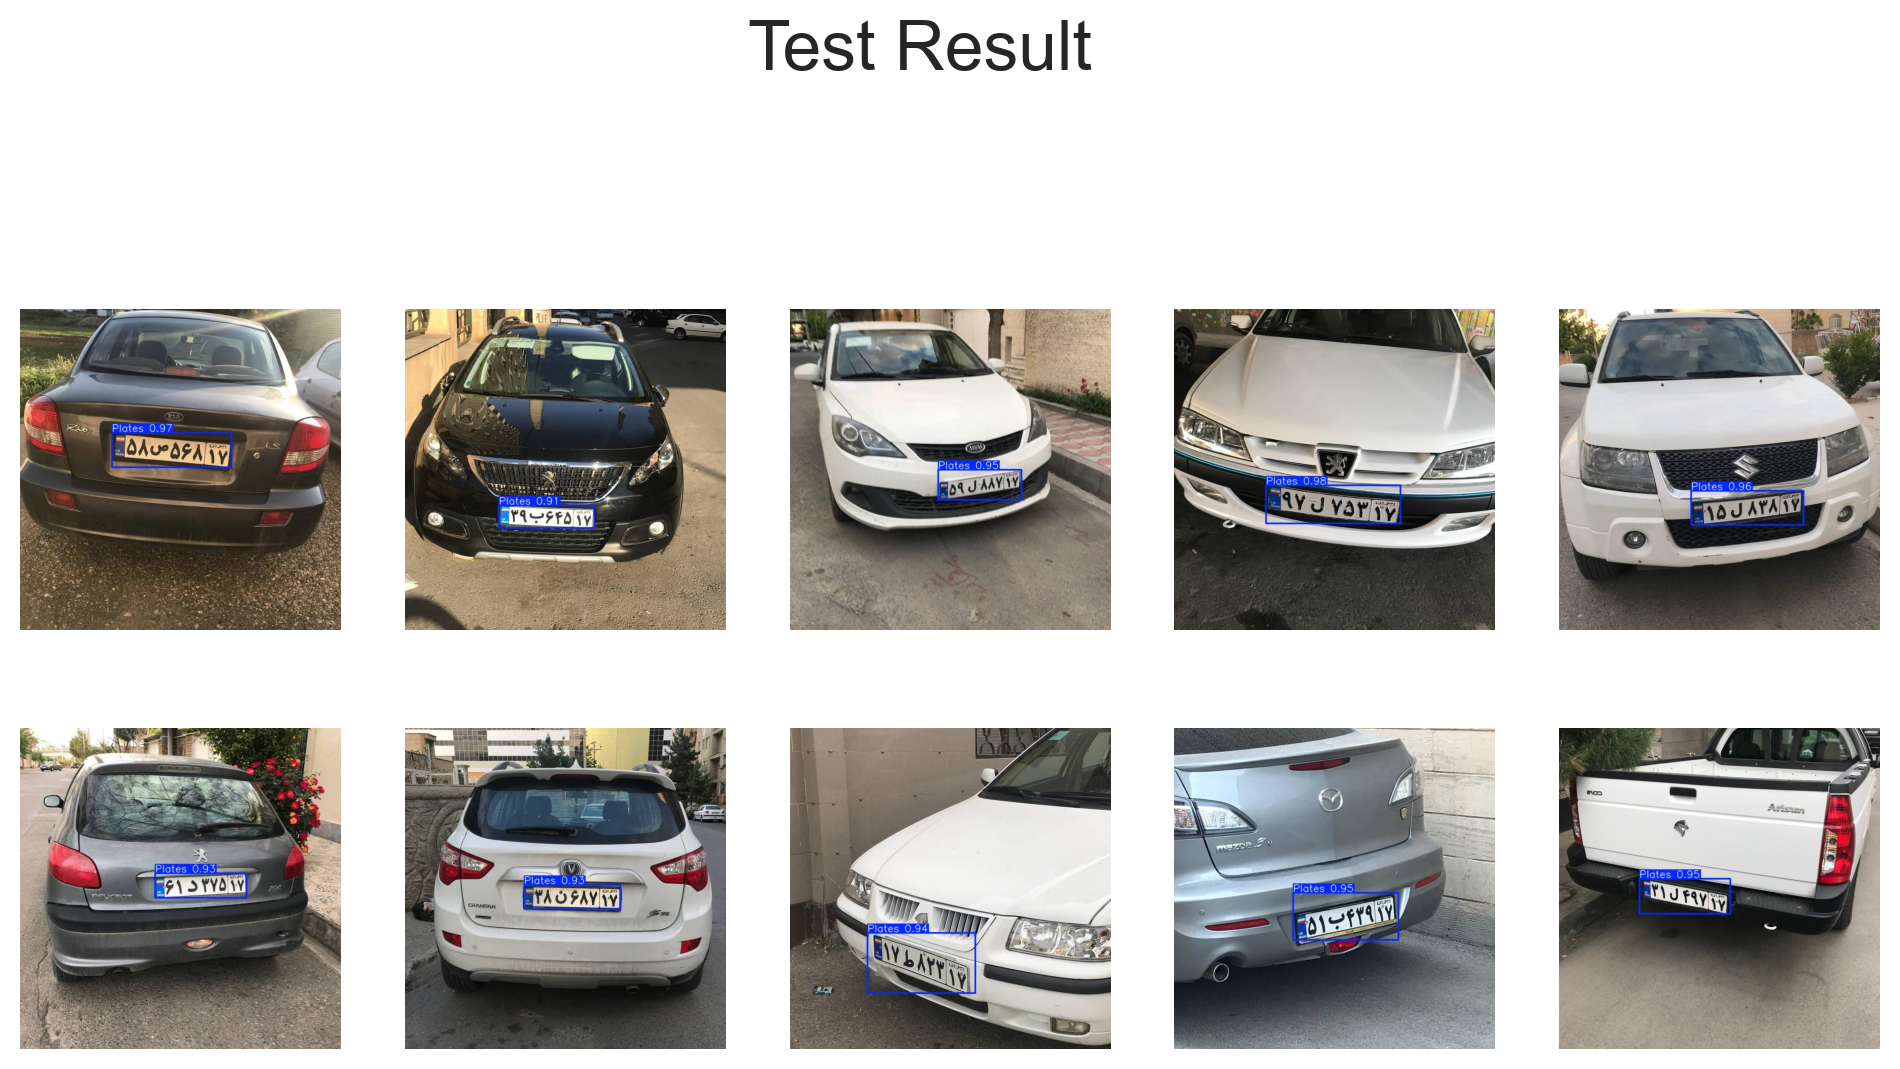

In [25]:
# Show images
i = 1
plt.figure(figsize=(12, 6), dpi=200)
for image in os.listdir(result_path) :
    image_path = os.path.join(result_path, image)
    plt.suptitle('Test Result', fontsize=25, fontweight=500)
    plt.subplot(2, 5, i)
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.subplots_adjust(top=0.75)
    i+=1
    if i==11 : break
plt.show()

In [26]:
result[0].boxes.xyxy.tolist()

[[269.87786865234375, 289.4159851074219, 451.999267578125, 338.5813293457031]]

# Phase 2 - Detect Plates Char and Digits

## Data Loading

In [27]:
# Path of car-detection dataset
digits_base = 'C:\\envs\\DataSets\\Persian Plates Digits.v1i.yolov8'

# Path of yaml file
digits_yaml_path = os.path.join(digits_base, 'data.yaml')

# Path of Train directory
digits_train_dir = os.path.join(digits_base, 'train')
digits_train_images = os.path.join(digits_train_dir, 'images')
digits_train_labels = os.path.join(digits_train_dir, 'labels')

# Path of Validation directory
digits_valid_dir = os.path.join(digits_base, 'valid')
digits_valid_images = os.path.join(digits_valid_dir, 'images')
digits_valid_labels = os.path.join(digits_valid_images, 'labels')

# Path of Test directory
digits_test_dir = os.path.join(digits_base, 'test')
digits_test_images = os.path.join(digits_test_dir, 'images')
digits_test_labels = os.path.join(digits_test_dir, 'labels')

In [28]:
print(colored(f' Number of Train Images : {len(os.listdir(digits_train_images))} ', 'blue', 'on_white', attrs=['bold']))
print(colored(f' Number of Validation Images : {len(os.listdir(digits_valid_images))}', 'blue', 'on_white',  attrs=['bold']))
print(colored(f' Number of Test Images : {len(os.listdir(digits_test_images))} ', 'blue', 'on_white',  attrs=['bold']))
print('_'*70)
print(colored(f' Number of All Images : {len(os.listdir(digits_train_images)) + len(os.listdir(digits_valid_images)) + len(os.listdir(digits_test_images))} ', 'green', 'on_white',  attrs=['bold']))

 Number of Train Images : 184 
 Number of Validation Images : 53
 Number of Test Images : 26 
______________________________________________________________________
 Number of All Images : 263 


## Image sizes

In [29]:
img_sizes_digits = Image_Size(digits_train_images)

if len(img_sizes_digits) == 1 :
    print(colored(f'\n All the images have size of {img_sizes_digits} ', 'white', 'on_green', attrs=['bold']))
else :
    print(colored(f'\n There are {len(img_sizes_digits)} different image sizes ! ', 'white', 'on_red', attrs=['bold']))


100%|██████████| 184/184 [00:00<00:00, 1274.97it/s]


 All the images have size of {(70, 200)} 


In [30]:
H_d = list(img_sizes_digits)[0][0]
W_d = list(img_sizes_digits)[0][1]

print(H_d, ',', W_d)

70 , 200


## Label Dict

In [31]:
classes_dict =  {
            '0':'0',
            '1':'1',
            '2':'2',
            '3':'3',
            '4':'4',
            '5':'5',
            '6':'6',
            '7':'7', 
            '8':'8',
            '9':'9',
            '10':'B',
            '11':'C',
            '12':'D',
            '13':'G', 
            '14':'H',
            '15':'J',
            '16':'L',
            '17':'M', 
            '18':'N', 
            '19':'S', 
            '20':'T', 
            '21':'V', 
            '22':'Y'
            }

## Plot Random Images With BBOXs

In [32]:
def draw_box(img, bboxes) :
    '''
    Read bboxes cordinates and calculate correct cordinates to draw rectangles. 
    '''
    for i in range(len(bboxes)) :  
        b1 = bboxes[i]
        b1 = b1.split(' ')

        label = classes_dict[b1[0]]

        x_center = float(b1[1]) * W_d
        y_center = float(b1[2]) * H_d
        w = float(b1[3]) * W_d
        h = float(b1[4]) * H_d

        x_min = round(x_center - (w / 2))
        x_max = round(x_center + (w / 2))
        y_min = round(y_center - (h / 2))
        y_max = round(y_center + (h / 2))

        x1 = round(x_center - w/4)
        x2 = round(x_center + w/4)

        y1 = round(3)
        y2 = round(10)

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1, cv2.LINE_AA)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), -1, cv2.LINE_AA)
        cv2.putText(img, label, (x1, y1+9), cv2.FONT_HERSHEY_COMPLEX, 0.35, (0, 255, 255), 1, cv2.LINE_AA)

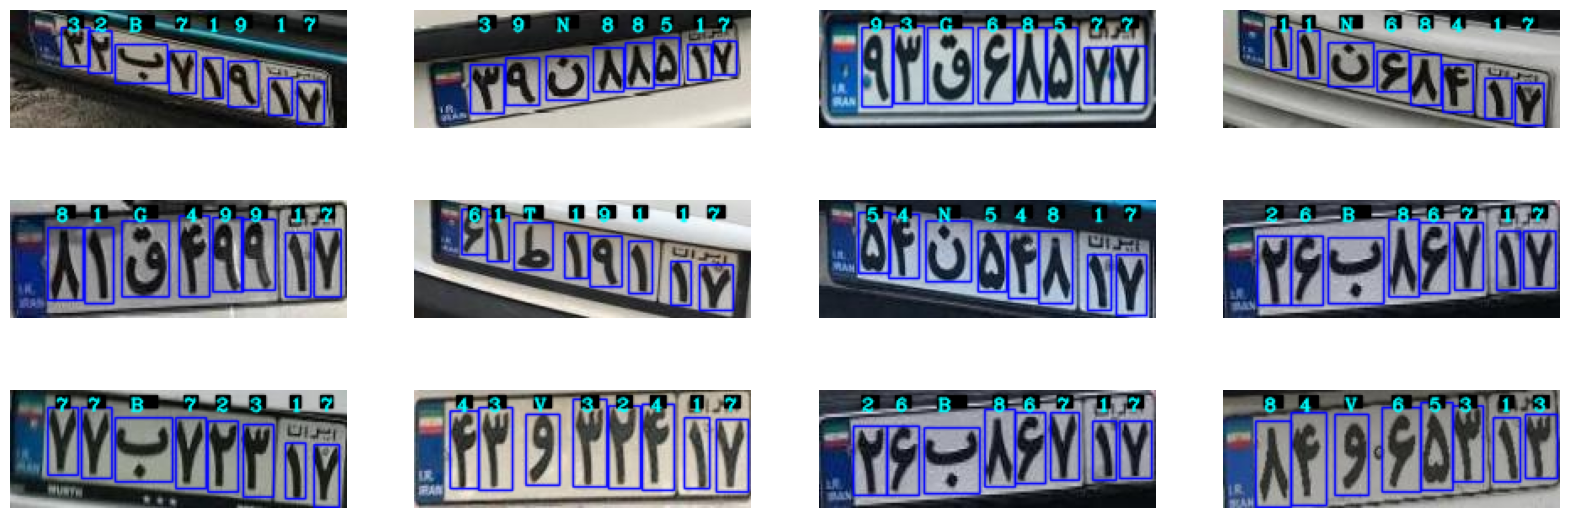

In [33]:
random_images = random.choices(os.listdir(digits_train_images), k=12)
i = 1
plt.figure(figsize=(20, 7))
for img_name in random_images :
    plt.subplot(3, 4, i)
    # Image
    img_path = os.path.join(digits_train_images, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # # BBox
    txt_name = JPG_Name_To_TXT(img_name)
    lbl_path = os.path.join(digits_train_labels, txt_name)
    bboxes = open(lbl_path)
    bboxes = bboxes.readlines()

    draw_box(img, bboxes)

    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.show()

## Model2 - Digits Detector

In [34]:
yolo_model = YOLO('yolov8n.yaml').load('yolov8n.pt')

result = yolo_model.train(data=digits_yaml_path, epochs=75, amp=False)

Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.2.48  Python-3.11.7 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=C:\envs\DataSets\Persian Plates Digits.v1i.yolov8\data.yaml, epochs=75, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_f

train: Scanning C:\envs\DataSets\Persian Plates Digits.v1i.yolov8\train\labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]
val: Scanning C:\envs\DataSets\Persian Plates Digits.v1i.yolov8\valid\labels.cache... 53 images, 0 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75       3.8G      1.575       4.62      1.379        120        640: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         53        423          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      3.77G      1.196      4.187      1.084        126        640: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         53        423          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      3.77G      1.145      3.701      1.041        126        640: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         53        423          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      3.77G      1.135      3.173      1.054        121        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         53        423      0.082     0.0493     0.0623     0.0497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      3.79G       1.14      2.663      1.081        146        640: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         53        423     0.0774      0.102      0.076     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      3.76G      1.115       2.26      1.064        179        640: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         53        423     0.0689      0.145     0.0961     0.0679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      3.77G       1.13       2.01      1.113        111        640: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         53        423     0.0625      0.184      0.111      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      3.78G      1.118      1.804      1.122        146        640: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         53        423      0.575      0.118      0.145      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      3.78G      1.099      1.641      1.106        171        640: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         53        423      0.753      0.141      0.176      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      3.76G      1.092      1.527      1.109        175        640: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         53        423      0.803      0.165      0.188      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      3.77G       1.07      1.381      1.106        135        640: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         53        423      0.765      0.166      0.226      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      3.76G      1.074      1.344      1.109        135        640: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         53        423      0.851      0.187       0.26      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      3.79G      1.087       1.28      1.118        108        640: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         53        423       0.85      0.217      0.312      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      3.76G      1.066       1.19      1.125        102        640: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         53        423      0.827       0.24      0.329      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      3.79G      1.072      1.161      1.117        120        640: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         53        423       0.88      0.248      0.332      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      3.78G      1.032      1.077      1.107        135        640: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         53        423      0.906       0.25       0.34      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      3.76G      1.031      1.039      1.106        139        640: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         53        423      0.904      0.295      0.347      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      3.76G      1.018      1.004        1.1        143        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         53        423      0.946      0.278      0.349      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      3.78G      1.031      1.017      1.107        123        640: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         53        423      0.929       0.28      0.352      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      3.77G      1.022     0.9629      1.091        141        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         53        423      0.945      0.288      0.364      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      3.79G      1.013     0.9593      1.083        130        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         53        423      0.934      0.292      0.367      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      3.76G      1.021     0.9563      1.086        115        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         53        423      0.951      0.318      0.381      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      3.79G     0.9881     0.9004      1.067        149        640: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         53        423      0.951      0.313      0.398      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      3.76G      1.015     0.9204      1.082        126        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         53        423      0.945      0.314      0.398       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      3.79G     0.9923     0.8943       1.07        162        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         53        423      0.963      0.314        0.4      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      3.78G     0.9681     0.8527      1.063        140        640: 100%|██████████| 12/12 [00:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         53        423      0.955      0.316      0.387      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      3.78G     0.9905     0.8721      1.082        128        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         53        423      0.952      0.314      0.389      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      3.76G     0.9893     0.8795      1.072        148        640: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         53        423      0.942       0.32       0.39      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      3.77G     0.9568     0.8528      1.058        135        640: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         53        423      0.943      0.319       0.39      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      3.79G     0.9558     0.8345      1.049        172        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         53        423      0.942      0.315       0.39      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      3.77G     0.9686     0.8316      1.073        123        640: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         53        423      0.939      0.309      0.391       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      3.78G     0.9669     0.8252      1.054        118        640: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         53        423      0.949      0.318      0.411      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      3.79G     0.9597     0.8214      1.065        133        640: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         53        423      0.949      0.313      0.405      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      3.77G     0.9599     0.8095      1.046        155        640: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         53        423      0.935      0.316      0.424      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      3.78G     0.9457     0.7947       1.05        152        640: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         53        423      0.919       0.32      0.422      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      3.77G     0.9345      0.791       1.05        164        640: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         53        423      0.887      0.341      0.422      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      3.79G     0.9311     0.7836      1.034        160        640: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         53        423      0.927      0.346      0.424      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      3.78G     0.9286     0.7627      1.044        121        640: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         53        423      0.952      0.349      0.424      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      3.79G       0.94     0.7914      1.044        204        640: 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         53        423      0.956      0.348      0.439      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      3.78G     0.9407     0.7824      1.046        120        640: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         53        423       0.95      0.343      0.433       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      3.76G     0.9284     0.7604      1.041        148        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         53        423      0.943      0.349      0.456       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      3.79G     0.9161     0.7425      1.031        142        640: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         53        423      0.949      0.346      0.454      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      3.78G     0.9167     0.7224      1.025        144        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         53        423       0.95      0.349      0.447      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      3.78G     0.9093      0.727      1.038        152        640: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         53        423      0.952      0.347      0.454      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      3.78G     0.8895     0.7246      1.014        141        640: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         53        423      0.952      0.345      0.463      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      3.79G     0.8984     0.7238      1.027        121        640: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         53        423      0.942      0.347      0.462      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      3.77G     0.9165     0.7501      1.028         93        640: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         53        423      0.906      0.354      0.464      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      3.76G     0.9041     0.7242      1.036        142        640: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         53        423      0.908      0.355      0.465       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      3.76G     0.8946     0.7141       1.02        140        640: 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         53        423      0.901      0.354      0.467      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      3.77G     0.9014     0.7091       1.03        110        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         53        423        0.9      0.354      0.464       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      3.78G     0.8848      0.707      1.023        138        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         53        423      0.908      0.355      0.465      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      3.77G     0.8866     0.6936      1.015        145        640: 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         53        423      0.903      0.355      0.464      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      3.77G     0.8831     0.6922      1.029        108        640: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         53        423      0.902      0.355      0.464      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      3.78G     0.8907     0.7092      1.025        122        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         53        423        0.9      0.352      0.468      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      3.77G     0.8737     0.7028      1.014        147        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         53        423      0.902      0.383      0.463       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      3.77G     0.8518     0.6799     0.9983        104        640: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         53        423      0.896      0.403      0.464      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      3.79G     0.8671     0.6791      1.004        120        640: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         53        423      0.885      0.403      0.464      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      3.76G     0.8513     0.6697      1.012        100        640: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         53        423      0.886      0.441      0.467      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      3.78G     0.8569      0.665      1.004        120        640: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         53        423      0.877      0.449      0.467      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      3.78G     0.8587     0.6808      1.007        158        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         53        423      0.885      0.449      0.466      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      3.76G     0.8597     0.6824      1.005        157        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         53        423      0.891      0.446      0.466      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      3.79G     0.8687     0.6756      1.018        129        640: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         53        423      0.886      0.448      0.465      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      3.79G      0.852     0.6571     0.9979        153        640: 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         53        423       0.88      0.449      0.465      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      3.79G     0.8486     0.6609     0.9992        127        640: 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         53        423      0.831      0.449      0.467      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      3.76G     0.8369     0.6503      1.001        148        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         53        423      0.835      0.449      0.468      0.335


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      3.88G     0.8959     0.8236      1.032         61        640: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         53        423      0.885      0.446      0.464       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      3.88G     0.8919     0.7697      1.009         61        640: 100%|██████████| 12/12 [00:06<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         53        423        0.9      0.391       0.45       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      3.88G     0.8561     0.7501      1.007         61        640: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         53        423      0.896      0.393      0.442      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      3.88G     0.8317     0.6956      1.004         61        640: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         53        423       0.87      0.418      0.433       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      3.88G     0.8257     0.6754       1.01         59        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         53        423      0.867      0.421      0.447      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      3.88G     0.8172      0.681     0.9946         63        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         53        423      0.847      0.403      0.439      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      3.88G     0.8057      0.659     0.9989         62        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         53        423      0.847        0.4       0.44      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      3.88G     0.8042     0.6631     0.9904         63        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         53        423      0.852      0.399      0.439      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      3.88G     0.8091     0.6647     0.9913         64        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         53        423      0.876      0.418      0.449       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      3.88G     0.8025     0.6493      1.002         62        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         53        423      0.872      0.418      0.449      0.321



75 epochs completed in 0.203 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.2.48  Python-3.11.7 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3010133 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


                   all         53        423      0.903      0.355      0.464      0.339
                     0          2          2          1          0      0.995        0.6
                     1         49         71      0.962      0.634      0.683      0.456
                     2         26         34      0.788      0.529      0.507      0.388
                     3         29         41      0.831      0.561      0.595       0.48
                     4         16         20      0.871       0.65      0.637      0.482
                     5         22         28      0.862      0.607      0.627      0.459
                     6         26         30      0.919      0.633      0.679      0.487
                     7         51         74      0.896      0.554       0.61      0.455
                     8         29         34      0.893      0.735      0.768      0.556
                     9         25         36      0.861      0.417      0.464      0.333
                     

## Train Result

In [35]:
# Location of stored result
result_path = result.save_dir

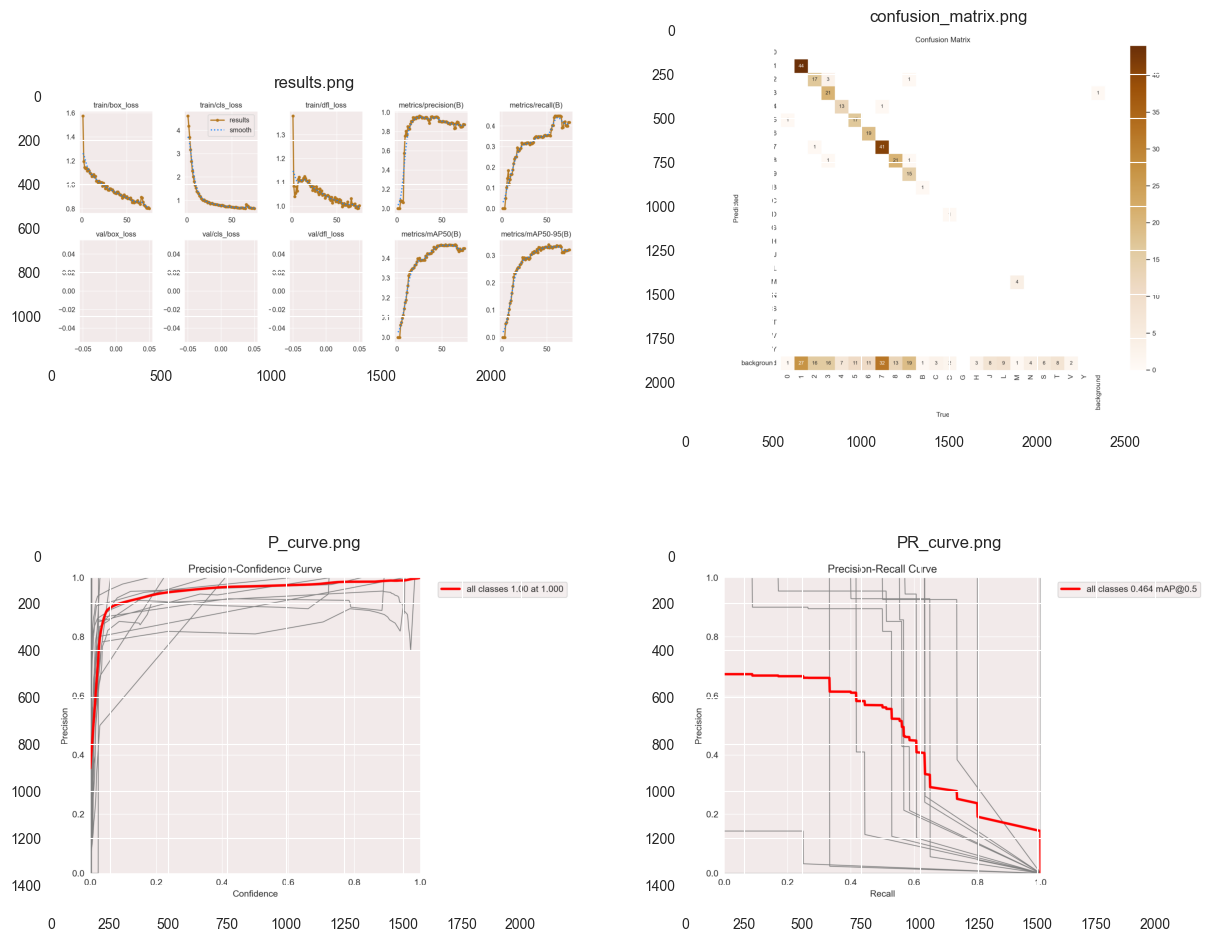

In [36]:
# List of some metrics
metrics = ['results.png','confusion_matrix.png', 'P_curve.png', 'PR_curve.png']

plt.figure(figsize=(15, 12))
i = 1

for image_name in metrics:
    image_path = os.path.join(result_path, image_name)
    image = cv2.imread(image_path)
    
    plt.subplot(2, 2, i)
    
    plt.imshow(image)
    plt.title(image_name)
    i += 1

plt.show()

In [37]:
# Read csv of result
df = pd.read_csv(os.path.join(result_path, 'results.csv'))
df.tail(5)

epoch        train/box_loss        train/cls_loss  \
70                    71               0.81724               0.68103   
71                    72               0.80565               0.65899   
72                    73               0.80422               0.66306   
73                    74               0.80910               0.66471   
74                    75               0.80248               0.64929   

          train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
70               0.99462               0.84654               0.40261   
71               0.99890               0.84701               0.39966   
72               0.99038               0.85179               0.39885   
73               0.99126               0.87571               0.41768   
74               1.00220               0.87180               0.41762   

        metrics/mAP50(B)   metrics/mAP50-95(B)             val/box_loss  \
70               0.43891               0.31659                      nan   
71               0.43989               0.31753                      nan   
72               0.43918               0.31765                      nan   
73               0.44887               0.31963                      nan   
74               0.44902               0.32076                      nan   

               val/cls_loss             val/dfl_loss                lr/pg0  \
70                      nan                      nan              0.000028   
71                      nan                      nan              0.000023   
72                      nan                      nan              0.000018   
73                      nan                      nan              0.000013   
74                      nan                      nan              0.000009   

                  lr/pg1                lr/pg2  
70              0.000028              0.000028  
71              0.000023              0.000023  
72              0.000018              0.000018  
73              0.000013              0.000013  
74              0.000009              0.000009

In [38]:
# Strip columns
df.columns = df.columns.str.strip()
df.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

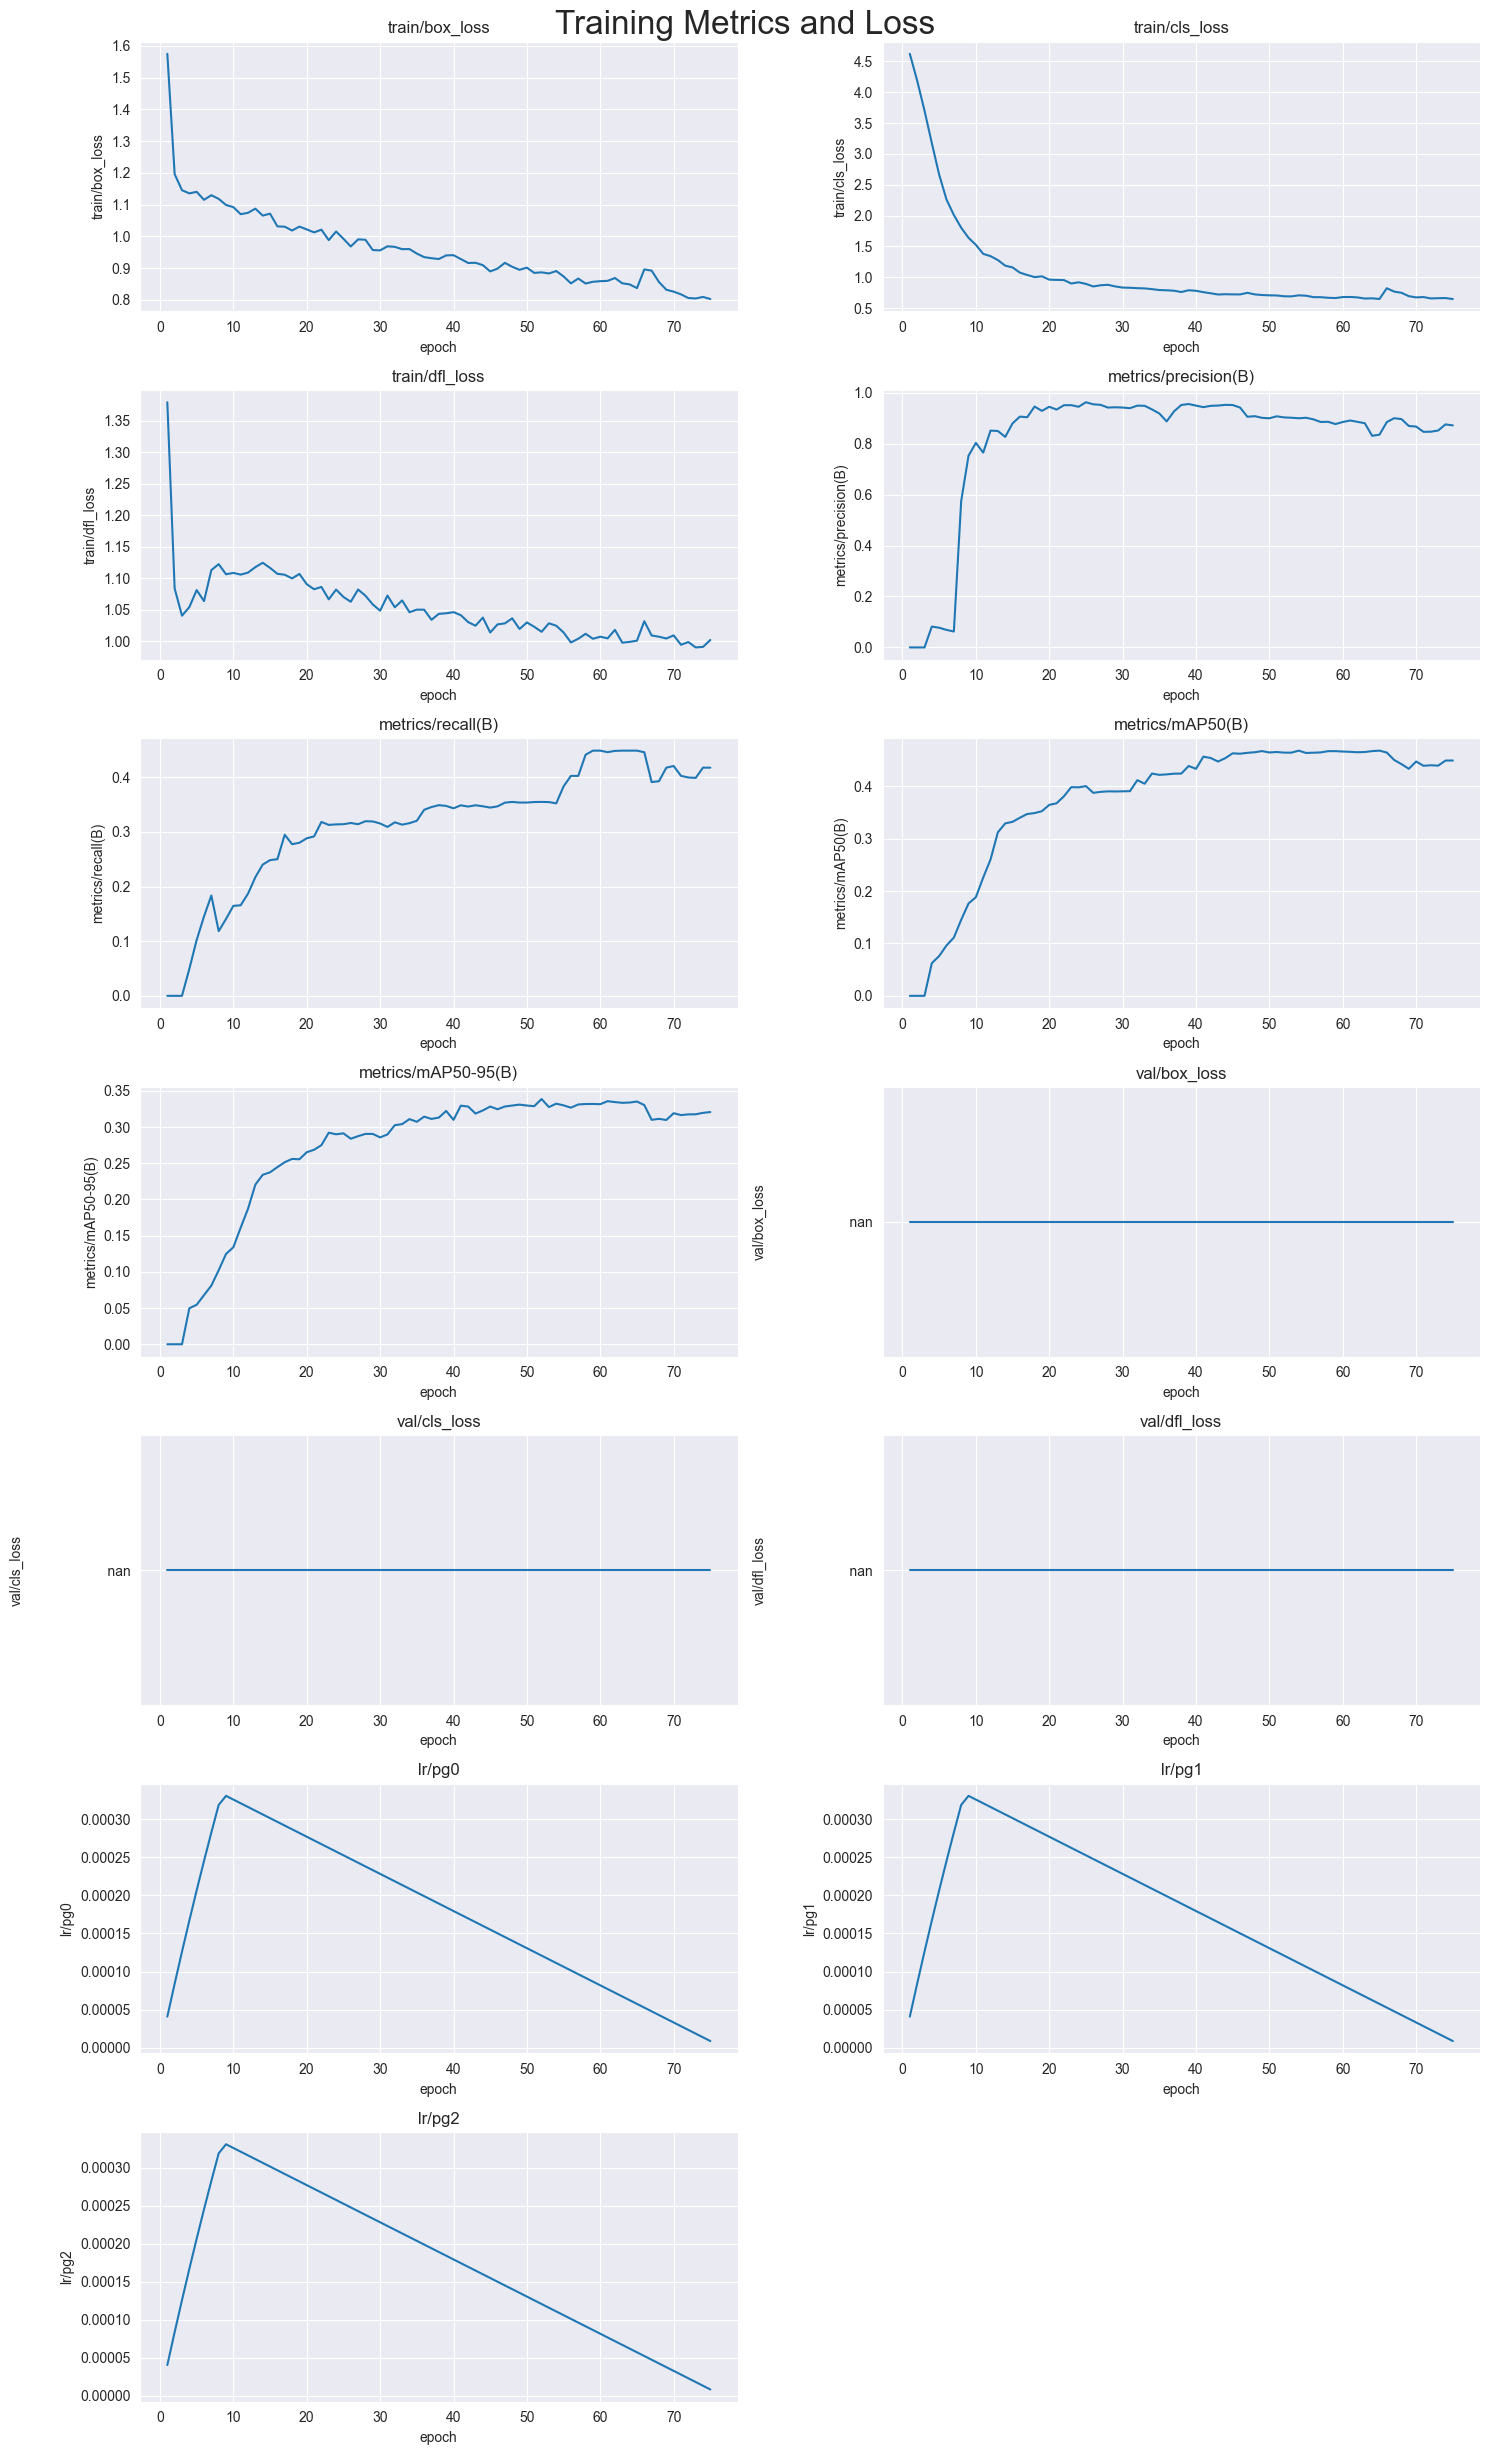

In [39]:
# Define X, y to plot
X = df.epoch
cols = df.columns[1:]

plt.figure(figsize=(15, 25))

for it in range(len(cols)) :
    plt.subplot(7, 2, it+1)
    ax = sns.lineplot(data=df, x=X, y=cols[it])
    ax.set_title(cols[it])
plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.6)
plt.tight_layout()
plt.show()

## Test the second model

In [40]:
# Load model with best weights
best_model_path = os.path.join(result_path, 'weights/best.pt')

best_model_digits = YOLO(best_model_path)

In [41]:
# Evaluating the model
result_test = best_model_digits.val()

Ultralytics YOLOv8.2.48  Python-3.11.7 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3010133 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\envs\DataSets\Persian Plates Digits.v1i.yolov8\valid\labels.cache... 53 images, 0 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


                   all         53        423      0.941      0.917      0.981      0.731
                     0          2          2          1          0      0.995      0.598
                     1         49         71      0.972       0.97       0.97      0.657
                     2         26         34      0.905      0.971      0.945       0.73
                     3         29         41      0.963      0.829      0.872      0.697
                     4         16         20      0.903       0.93      0.965      0.715
                     5         22         28          1      0.999      0.995      0.703
                     6         26         30      0.959          1      0.964      0.691
                     7         51         74      0.984      0.973      0.993      0.741
                     8         29         34      0.941      0.944      0.986       0.71
                     9         25         36      0.996      0.944      0.965      0.725
                     

In [42]:
result_test

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002206A7F3FD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042, 

In [43]:
keys = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

for key in keys :
    print(colored(f'{key} : {result_test.results_dict[key]}', 'green', attrs=['bold']))

metrics/precision(B) : 0.9408412242501896
metrics/recall(B) : 0.91719336009496
metrics/mAP50(B) : 0.9806758083119866
metrics/mAP50-95(B) : 0.7308237625993687


In [44]:
images = os.listdir(digits_test_images)
num_samples = 12

random_images = random.choices(images, k=num_samples)

images = []
for image in random_images :
    image_path = os.path.join(digits_test_images, image)
    images.append(image_path)

images

['C:\\envs\\DataSets\\Persian Plates Digits.v1i.yolov8\\test\\images\\61_jpg.rf.6df1b5548671713cfa7a36dbbd42d5d1.jpg',
 'C:\\envs\\DataSets\\Persian Plates Digits.v1i.yolov8\\test\\images\\54_jpg.rf.9d4b7a67207e8e52ac628cbd76df0ddb.jpg',
 'C:\\envs\\DataSets\\Persian Plates Digits.v1i.yolov8\\test\\images\\22_jpg.rf.f798bd832b2e1d95302720942007f1f4.jpg',
 'C:\\envs\\DataSets\\Persian Plates Digits.v1i.yolov8\\test\\images\\196_jpg.rf.768776fda1ac20bf1d4cd7fd675e6adc.jpg',
 'C:\\envs\\DataSets\\Persian Plates Digits.v1i.yolov8\\test\\images\\267_jpg.rf.8d596a05a2593b4c4c8d26f1e58c0ff5.jpg',
 'C:\\envs\\DataSets\\Persian Plates Digits.v1i.yolov8\\test\\images\\22_jpg.rf.f798bd832b2e1d95302720942007f1f4.jpg',
 'C:\\envs\\DataSets\\Persian Plates Digits.v1i.yolov8\\test\\images\\59_jpg.rf.c259541051cd6f20cb3096ebfec0ff8e.jpg',
 'C:\\envs\\DataSets\\Persian Plates Digits.v1i.yolov8\\test\\images\\20_jpg.rf.3c4fbabcb54da1b324daff922ccefe87.jpg',
 'C:\\envs\\DataSets\\Persian Plates Digits.v1

In [45]:
for image in images :
    result = best_model_digits.predict([image], save=True, conf=0.5, iou=0.7)


0: 224x640 2 1s, 1 2, 1 3, 2 5s, 1 7, 1 B, 49.8ms
Speed: 0.0ms preprocess, 49.8ms inference, 10.4ms postprocess per image at shape (1, 3, 224, 640)
Results saved to runs\detect\predict4

0: 224x640 1 1, 1 2, 1 5, 1 6, 2 7s, 1 8, 1 N, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 9.8ms postprocess per image at shape (1, 3, 224, 640)
Results saved to runs\detect\predict4

0: 224x640 3 1s, 1 3, 1 7, 1 8, 1 9, 1 G, 22.5ms
Speed: 0.0ms preprocess, 22.5ms inference, 4.0ms postprocess per image at shape (1, 3, 224, 640)
Results saved to runs\detect\predict4

0: 224x640 1 1, 1 2, 1 5, 1 6, 1 7, 1 8, 1 9, 1 N, 21.7ms
Speed: 0.0ms preprocess, 21.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)
Results saved to runs\detect\predict4

0: 224x640 1 1, 2 2s, 1 3, 1 4, 1 6, 1 8, 1 H, 20.1ms
Speed: 1.5ms preprocess, 20.1ms inference, 3.4ms postprocess per image at shape (1, 3, 224, 640)
Results saved to runs\detect\predict4

0: 224x640 3 1s, 1 3, 1 7, 1 8, 1 9, 1 G, 17.9ms
Speed:

In [46]:
# Location of saved predicted images
result_path = result[0].save_dir
print(result_path)

runs\detect\predict4


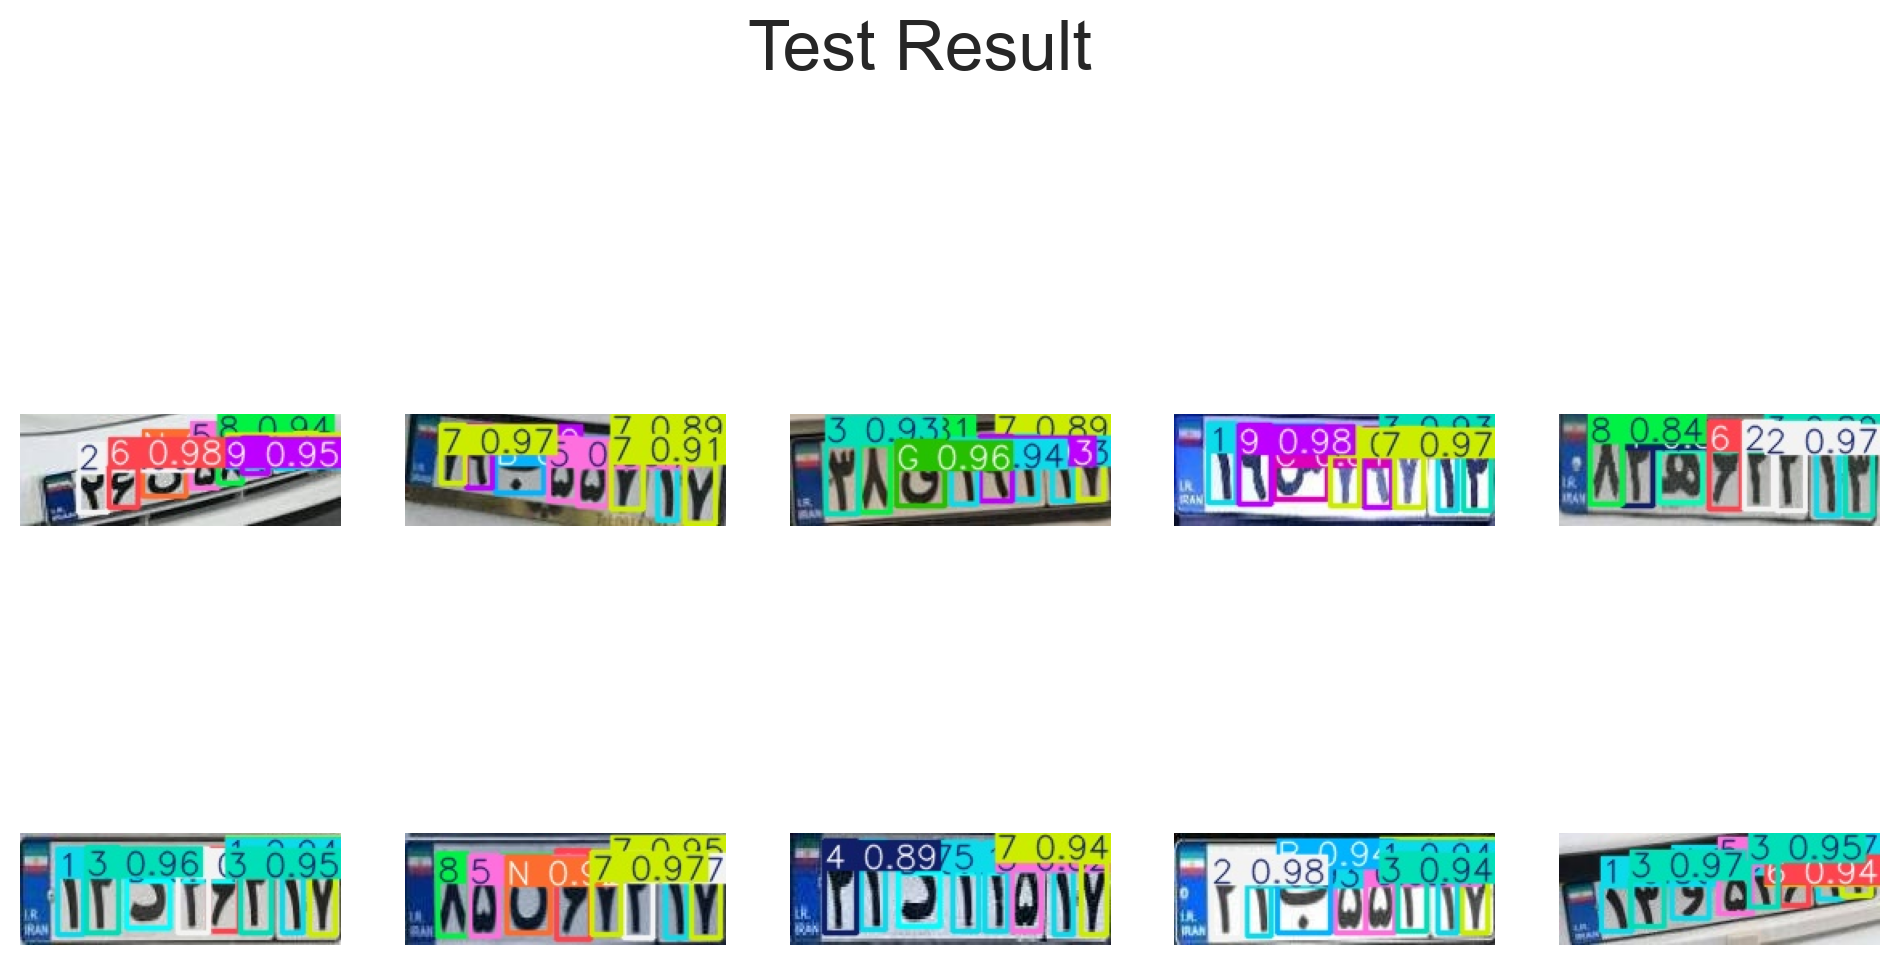

In [47]:
# Show images
i = 1
plt.figure(figsize=(12, 6), dpi=200)
for image in os.listdir(result_path) :
    image_path = os.path.join(result_path, image)
    plt.suptitle('Test Result', fontsize=25, fontweight=500)
    plt.subplot(2, 5, i)
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.subplots_adjust(top=0.75)
    i+=1
    if i==11 : break
plt.show()

# Phase 3 - Make a PipeLine of both models

In [228]:
extra = os.path.join(plate_base, 'extra')
os.listdir(extra)

['raw_plate.png', 'test.jpg', 'test2.jpg']

In [231]:
raw_plate = os.path.join(extra, 'raw_plate.png')
img_path = os.path.join(extra, 'test.jpg')

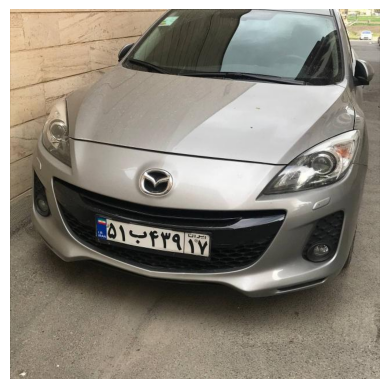

In [125]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

In [152]:
def Detect_Plate(img):
    '''
    Predict on a car image and return result folder and predicted image path. 
    '''
    result1 = best_model_plate.predict([img], save=True, iou=0.7)
    # Location of saved predicted images
    result_path1 = result1[0].save_dir

    pred1_path = os.path.join(result_path1, os.listdir(result_path1)[-1])
    return result1, pred1_path

result1, pred1_path = Detect_Plate(img)


0: 640x640 1 Plates, 21.0ms
Speed: 107.0ms preprocess, 21.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3


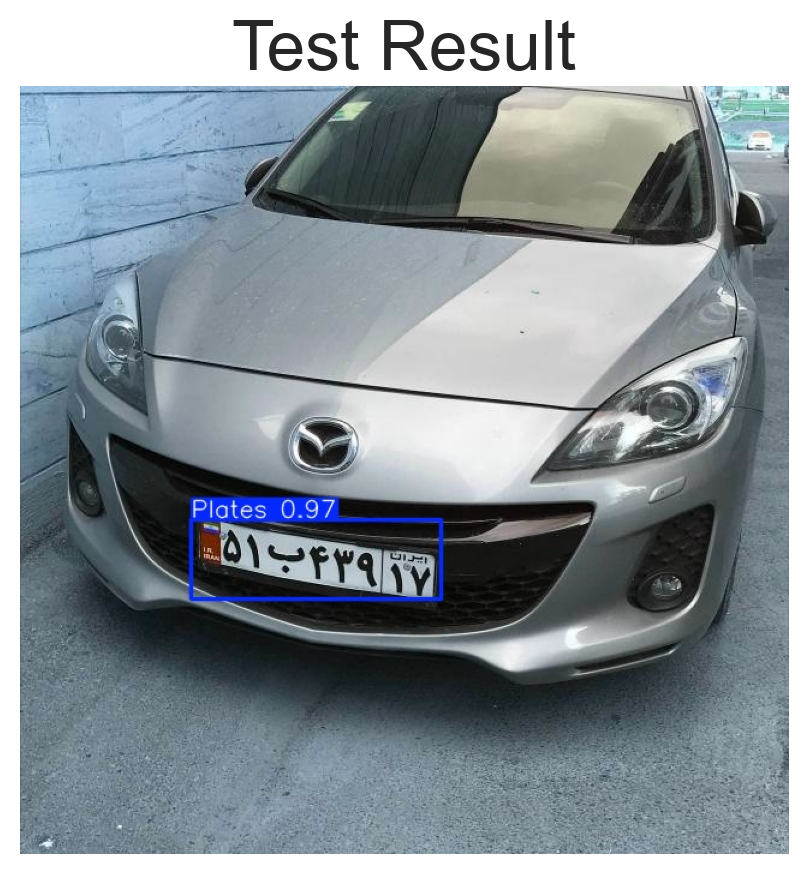

In [127]:
# Show images
plt.figure(figsize=(12, 6), dpi=200)

plt.title('Test Result', fontsize=25, fontweight=500)

plt.imshow(plt.imread(pred1_path))
plt.axis('off')
plt.subplots_adjust(top=0.75)


plt.show()

In [138]:
pts = result1[0].boxes.xyxy.tolist()[0]
pts

[142.63034057617188, 361.2798156738281, 350.43701171875, 427.4041442871094]

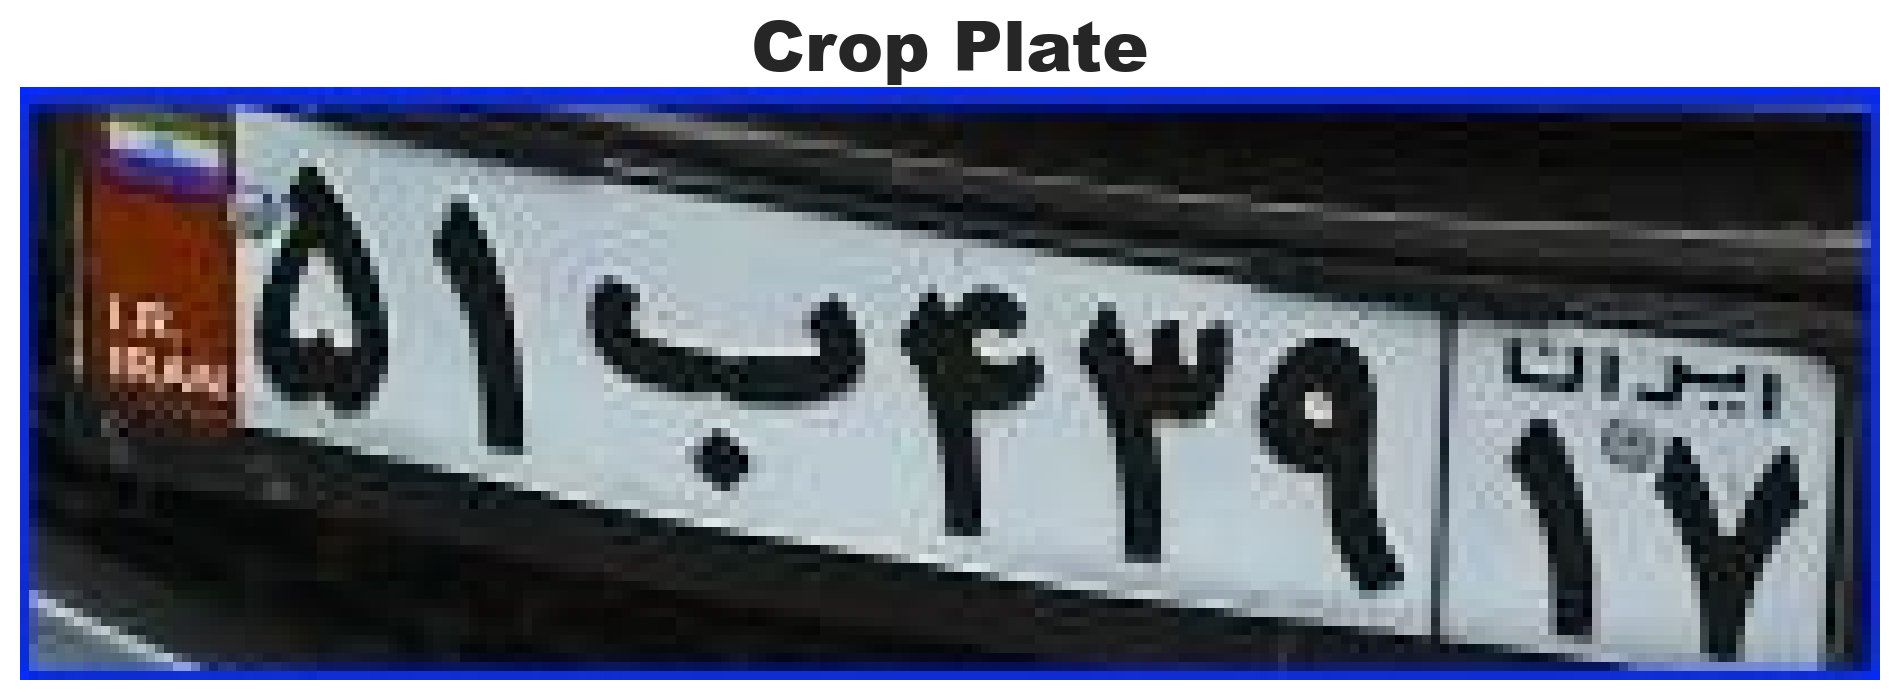

In [139]:
# Crop Plate
plt.figure(figsize=(12, 6), dpi=200)

plt.title('Crop Plate', fontsize=25, fontweight=900)

img = cv2.imread(pred1_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = img[round(pts[1]):round(pts[3]), round(pts[0]):round(pts[2])]
plt.imshow(img2)
plt.axis('off')
plt.subplots_adjust(top=0.75)

plt.show()

In [130]:
img2 = cv2.resize(img2, dsize=(120, 70))

In [185]:
def Detect_Digits(img2) :
    '''
    Predict on a croped plate and return result folder and predicted image.
    '''
    result2 = best_model_digits.predict([img2], save=True, iou=0.7, show_conf=False)
    # Location of saved predicted images
    result_path = result2[0].save_dir
    pred2_path = os.path.join(result_path, os.listdir(result_path)[-1])
    return result2, pred2_path

result2, pred2_path = Detect_Digits(img2)


0: 224x640 2 1s, 1 3, 1 4, 1 5, 1 7, 1 9, 1 B, 69.0ms
Speed: 3.7ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)
Results saved to runs\detect\predict4


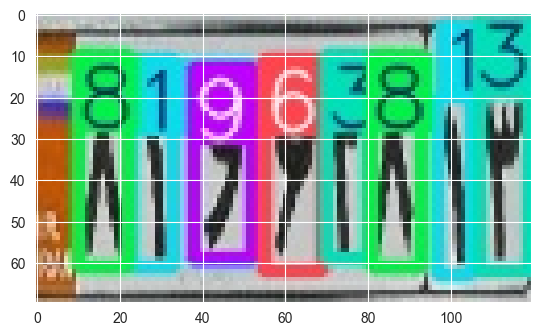

In [202]:
plt.imshow(plt.imread(pred2_path))

In [209]:
def Sort_Digits(result2) :
    '''
    Sort detected labels base on their X-cordinate,
    --- Sort from lef to right ---
    '''
    list_of_items = []
    for i in range(len(result2[0])) :
        class_label = classes_dict[str(int(result2[0][i].boxes.cls))]
        cord_x = int(result2[0][i].boxes.xyxy[0][0])
        list_of_items.append((cord_x, class_label))

    list_of_items.sort()
    list_of_items

    digits = []
    for digit in list_of_items :
        digits.append(digit[1])
    if len(digits) == 7 : digits.append('0')
    return digits

digits = Sort_Digits(result2)
digits

['5', '1', 'B', '4', '3', '9', '1', '7']

In [144]:
final = f' {digits[0]}{digits[1]} {digits[2]} {digits[3]}{digits[4]}{digits[5]} - Iran {digits[6]}{digits[-1]} '
print(colored(final, 'white', 'on_blue', attrs=['bold']))

 51 B 439 - Iran 17 


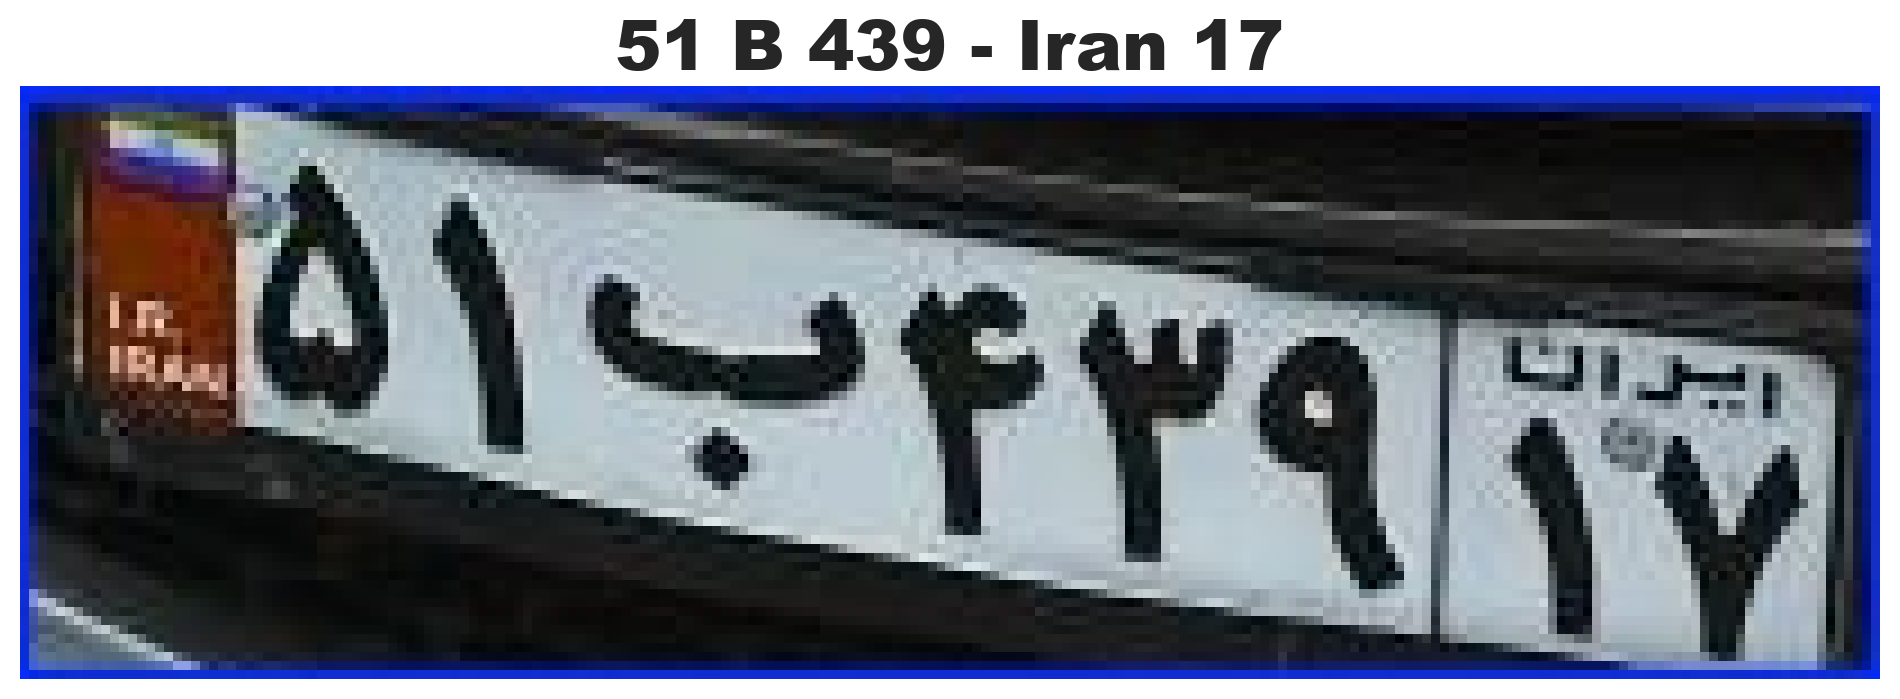

In [145]:
plt.figure(figsize=(12, 6), dpi=200)

plt.title(final, fontsize=25, fontweight=900)

img = cv2.imread(pred1_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = img[round(pts[1]):round(pts[3]), round(pts[0]):round(pts[2])]
plt.imshow(img2)
plt.axis('off')
plt.subplots_adjust(top=0.75)

plt.show()

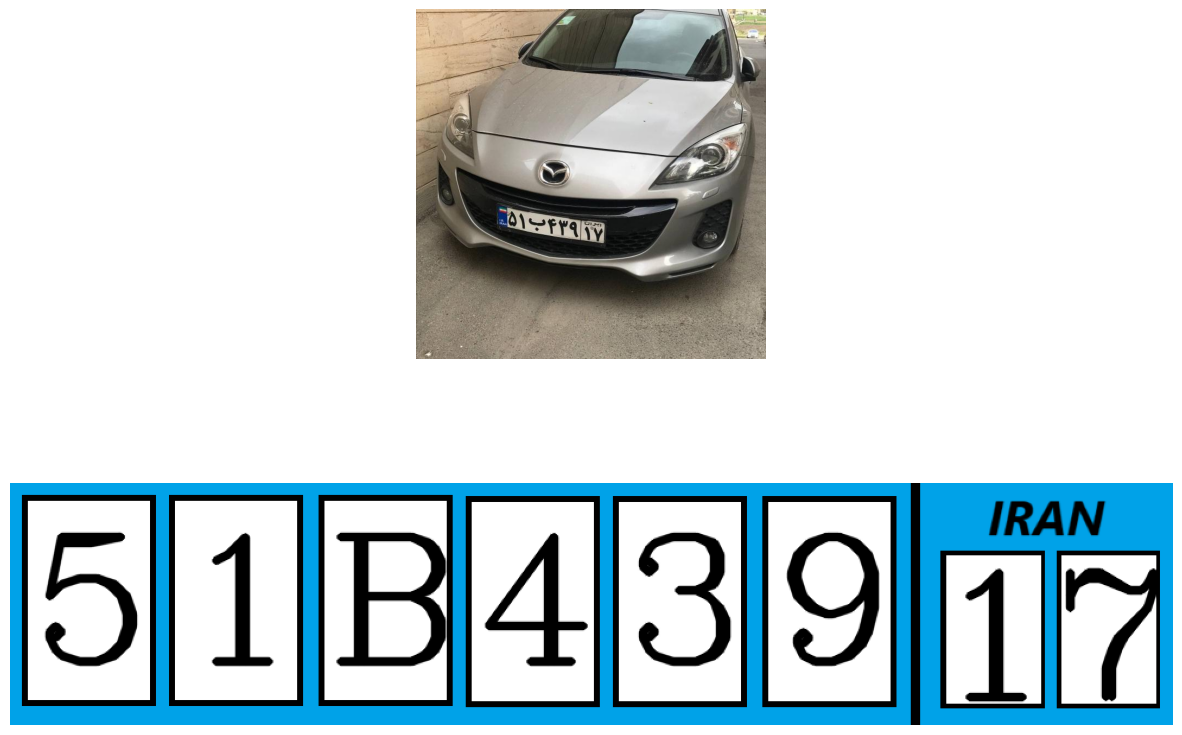

In [147]:
def Plot_Result(img, raw_plate, digits) :
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis('off')


    plt.subplot(2, 1, 2)
    raw_plate = cv2.imread(raw_plate)
    raw_plate = cv2.cvtColor(raw_plate, cv2.COLOR_BGR2RGB)


    p1 = (18, 150)
    p2 = (143, 150)
    p3 = (268, 150)
    p4 = (393, 150)
    p5 = (518, 150)
    p6 = (643, 150)
    p7 = (778, 180)
    p8 = (878, 180)

    cv2.putText(raw_plate, digits[0], p1, cv2.FONT_HERSHEY_COMPLEX, 5, (0, 0, 0), 5, cv2.LINE_AA)
    cv2.putText(raw_plate, digits[1], p2, cv2.FONT_HERSHEY_COMPLEX, 5, (0, 0, 0), 5, cv2.LINE_AA)
    cv2.putText(raw_plate, digits[2], p3, cv2.FONT_HERSHEY_COMPLEX, 5, (0, 0, 0), 5, cv2.LINE_AA)
    cv2.putText(raw_plate, digits[3], p4, cv2.FONT_HERSHEY_COMPLEX, 5, (0, 0, 0), 5, cv2.LINE_AA)
    cv2.putText(raw_plate, digits[4], p5, cv2.FONT_HERSHEY_COMPLEX, 5, (0, 0, 0), 5, cv2.LINE_AA)
    cv2.putText(raw_plate, digits[5], p6, cv2.FONT_HERSHEY_COMPLEX, 5, (0, 0, 0), 5, cv2.LINE_AA)
    cv2.putText(raw_plate, digits[6], p7, cv2.FONT_HERSHEY_COMPLEX, 5, (0, 0, 0), 5, cv2.LINE_AA)
    cv2.putText(raw_plate, digits[7], p8, cv2.FONT_HERSHEY_COMPLEX, 5, (0, 0, 0), 5, cv2.LINE_AA)



    plt.axis('off')
    plt.imshow(raw_plate)
    plt.show()

Plot_Result(img, raw_plate, digits)

# Final Model

In [220]:
def FINAL(img_path) :
    '''
    A pipeline for all parts of phase 3.
    start with a car image.
    result is digits and char on car plate.
    '''
    # Read car image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # First prediction -> Detect car-plate
    result1, pred1_path = Detect_Plate(img)

    # Plate Cordinates
    pts = result1[0].boxes.xyxy.tolist()[0]

    # Crop plate
    img2 = img[round(pts[1]):round(pts[3]), round(pts[0]):round(pts[2])]

    # Resize plate to feed to second model
    img2 = cv2.resize(img2, dsize=(120, 70))

    # Second prediction -> Detect digits in plate
    result2, pred2_path = Detect_Digits(img2)

    # Sort detected digits
    digits = Sort_Digits(result2)

    Plot_Result(img, raw_plate, digits)


0: 640x640 1 Plates, 105.0ms
Speed: 6.5ms preprocess, 105.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3

0: 384x640 2 1s, 1 3, 1 4, 1 5, 1 7, 1 9, 1 B, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict4


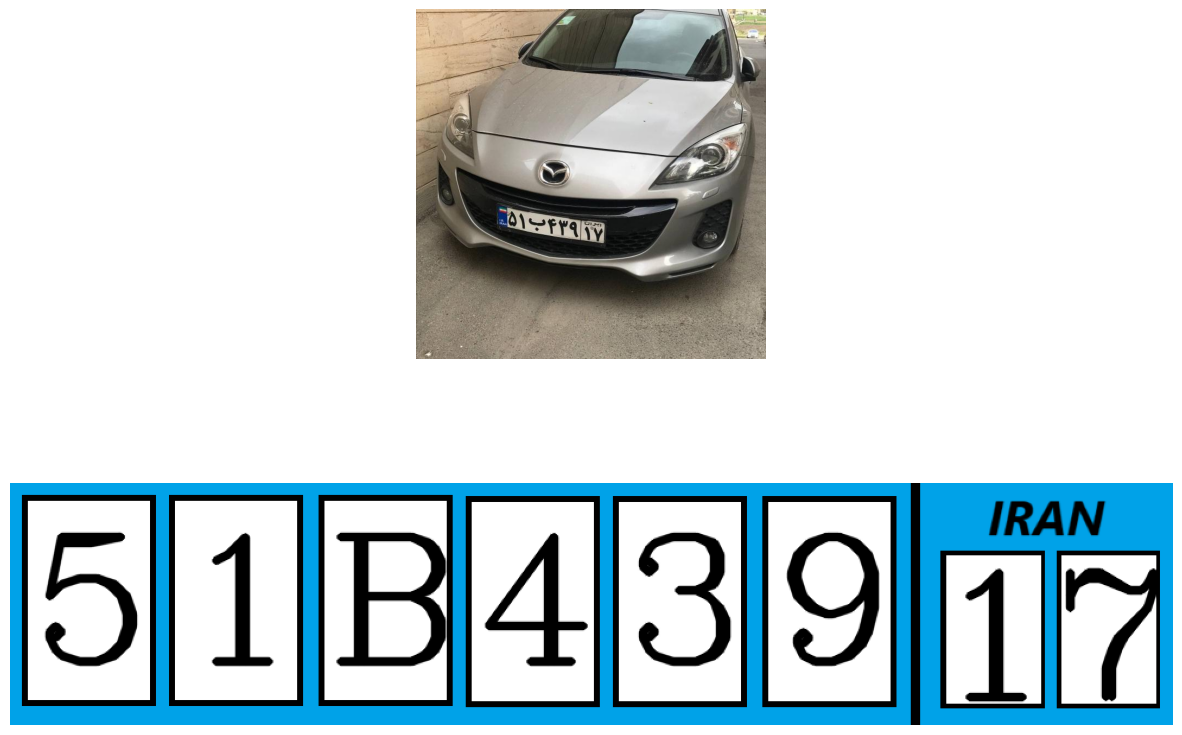

In [232]:
img_path = os.path.join(extra, 'test.jpg')

FINAL(img_path)


0: 640x640 1 Plates, 169.3ms
Speed: 24.3ms preprocess, 169.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3

0: 384x640 2 2s, 1 7, 1 8, 2 9s, 1 D, 82.2ms
Speed: 3.9ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict4


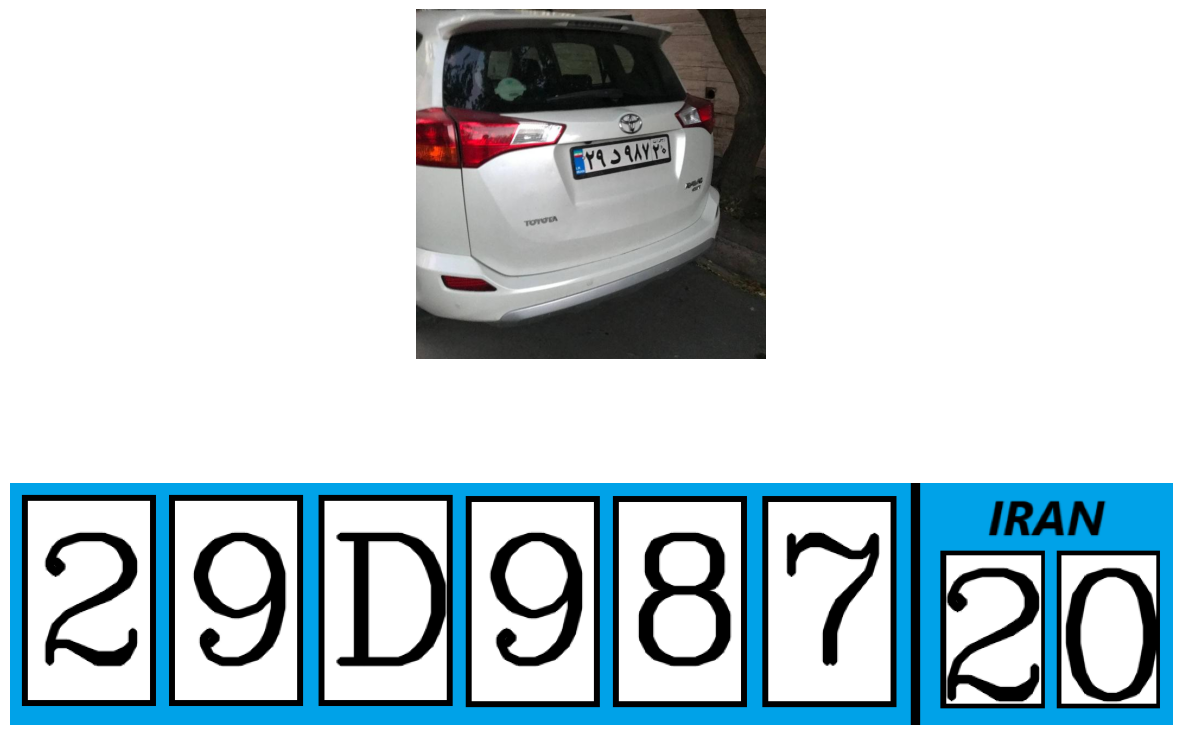

In [233]:
img_path = os.path.join(extra, 'test2.jpg')
FINAL(img_path)